In [1]:
import flwr as fl
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import joblib
import random
import os
from sklearn.svm import SVC
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

from flwr.common import parameters_to_ndarrays
from typing import List, Dict, Tuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-29 01:15:44,287	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
# --- CNN 모델 (클라이언트 용) ---
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [3]:
class DAGMM(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super(DAGMM, self).__init__()
        self.latent_dim = latent_dim

        # Encoder: feature -> latent
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 60),
            nn.Tanh(),
            nn.Linear(60, 30),
            nn.Tanh(),
            nn.Linear(30, latent_dim)
        )

        # Decoder: latent -> reconstruction
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 30),
            nn.Tanh(),
            nn.Linear(30, 60),
            nn.Tanh(),
            nn.Linear(60, input_dim)
        )

        # Estimation network: latent + reconstruction error -> gamma (energy)
        self.estimation = nn.Sequential(
            nn.Linear(latent_dim + 1, 10),
            nn.Tanh(),
            nn.Linear(10, 1),
            nn.Sigmoid()  # Optional depending on energy interpretation
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        recon_error = torch.mean((x - reconstructed) ** 2, dim=1, keepdim=True)
        z = torch.cat([latent, recon_error], dim=1)
        energy = self.estimation(z)
        return latent, reconstructed, energy


    def compute_loss(self, x, reconstructed, energy):
        recon_loss = F.mse_loss(reconstructed, x, reduction="mean")
        energy_loss = energy.mean()
        return recon_loss + 0.1 * energy_loss  # λ 조정 가능


In [4]:
# --- FL 클라이언트들 ---
class FederatedClient(fl.client.NumPyClient):
    def __init__(self, cid, model, train_loader, test_loader, epochs=10):
        self.cid = cid
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.epochs = epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.loss_fn = nn.CrossEntropyLoss()
        self.model.to(self.device)

    def get_type(self):
        return self.__class__.__name__.replace("Client", "").lower()

    def get_parameters(self, config): return [p.cpu().detach().numpy() for p in self.model.parameters()]
    
    def set_parameters(self, parameters):
        for p, new_p in zip(self.model.parameters(), parameters):
            p.data = torch.tensor(new_p, dtype=torch.float32, device=device)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.train()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)
        for _ in range(self.epochs):
            for x, y in self.train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                loss = nn.CrossEntropyLoss()(self.model(x), y)
                loss.backward()
                optimizer.step()
        return self.get_parameters(config), len(self.train_loader.dataset), {"cid": self.cid}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for x, y in self.test_loader:
                x, y = x.to(self.device), y.to(self.device)
                outputs = self.model(x)
                loss += self.loss_fn(outputs, y).item() * x.size(0)
                predicted = outputs.argmax(1)
                correct += (predicted == y).sum().item()
                total += y.size(0)

        avg_loss = loss / total
        accuracy = correct / total

        return avg_loss, total, {"accuracy": accuracy, "cid": self.cid}  # ✅ 반드시 3개 반환


In [5]:
# --- 클라이언트 행동 변종 ---
class LazyClient(FederatedClient):
    def __init__(self, cid, model, train_loader, test_loader):
        super().__init__(cid, model, train_loader, test_loader, epochs=5)
    
    def get_type(self):
        return self.__class__.__name__.replace("Client", "").lower()

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.train()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01)
        for _ in range(5):  # 적게 학습
            for x, y in self.train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                loss = nn.CrossEntropyLoss()(self.model(x), y)
                loss.backward()
                optimizer.step()
        return self.get_parameters(config), len(self.train_loader.dataset), {"cid": self.cid}
    
    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        self.model.eval()
        loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for x, y in self.test_loader:
                x, y = x.to(device), y.to(device)
                outputs = self.model(x)
                loss += self.loss_fn(outputs, y).item() * x.size(0)
                predicted = outputs.argmax(1)
                correct += (predicted == y).sum().item()
                total += y.size(0)

        avg_loss = loss / total
        accuracy = correct / total
        return avg_loss, total, {"accuracy": accuracy, "cid": self.cid}

class RandomClient(FederatedClient):
    def __init__(self, cid, model, train_loader, test_loader):
        super().__init__(cid, model, train_loader, test_loader)
        
    def get_type(self):
        return self.__class__.__name__.replace("Client", "").lower()

    def fit(self, parameters, config):
        shape_params = [np.random.randn(*p.shape).astype(np.float32) for p in parameters]
        return shape_params, len(self.train_loader.dataset), {"cid": self.cid}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        self.model.eval()
        loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for x, y in self.test_loader:
                x, y = x.to(device), y.to(device)
                outputs = self.model(x)
                loss += self.loss_fn(outputs, y).item() * x.size(0)
                predicted = outputs.argmax(1)
                correct += (predicted == y).sum().item()
                total += y.size(0)

        avg_loss = loss / total
        accuracy = correct / total
        return avg_loss, total, {"accuracy": accuracy, "cid": self.cid}
    
class EchoClient(FederatedClient):
    def __init__(self, cid, model, train_loader, test_loader):
        super().__init__(cid, model, train_loader, test_loader)
        self.buffer = []
        self.round = 0
    def get_type(self):
        return self.__class__.__name__.replace("Client", "").lower()

    def fit(self, parameters, config):
        self.round += 1
        self.buffer.append(parameters)

        if self.round <= 2:
            print(f"[EchoClient] Round {self.round}: returning current parameters (initial phase)")
            return parameters, len(self.train_loader.dataset), {"cid": self.cid}
        else:
            echoed = self.buffer[-3]  # 2 라운드 이전의 파라미터 반환
            print(f"[EchoClient] Round {self.round}: returning parameters from round {self.round - 2}")
            return echoed, len(self.train_loader.dataset), {"cid": self.cid}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        self.model.eval()
        loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for x, y in self.test_loader:
                x, y = x.to(device), y.to(device)
                outputs = self.model(x)
                loss += self.loss_fn(outputs, y).item() * x.size(0)
                predicted = outputs.argmax(1)
                correct += (predicted == y).sum().item()
                total += y.size(0)

        avg_loss = loss / total
        accuracy = correct / total
        return avg_loss, total, {"accuracy": accuracy, "cid": self.cid}

class SmallClient(FederatedClient):
    def __init__(self, cid, model, train_loader, test_loader):
        # train_loader의 데이터 수가 적어야 비정상으로 간주되도록!
        small_train_loader = torch.utils.data.DataLoader(
            list(train_loader.dataset)[:200],  # 작은 부분만 사용
            batch_size=32, shuffle=True
        )
        super().__init__(cid, model, small_train_loader, test_loader, epochs=10)

    def get_type(self):
        return self.__class__.__name__.replace("Client", "").lower()

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.train()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)
        for _ in range(self.epochs):
            for x, y in self.train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                loss = nn.CrossEntropyLoss()(self.model(x), y)
                loss.backward()
                optimizer.step()
        return self.get_parameters(config), len(self.train_loader.dataset), {"cid": self.cid}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for x, y in self.test_loader:
                x, y = x.to(self.device), y.to(self.device)
                outputs = self.model(x)
                loss += self.loss_fn(outputs, y).item() * x.size(0)
                predicted = outputs.argmax(1)
                correct += (predicted == y).sum().item()
                total += y.size(0)

        avg_loss = loss / total
        accuracy = correct / total

        return avg_loss, total, {"accuracy": accuracy, "cid": self.cid}  # ✅ 반드시 3개 반환



In [6]:
# --- 클라이언트 분류 ---
def classify_client(parameters, dagmm_model, svm_model):
    ndarrays = parameters_to_ndarrays(parameters)
    flat = np.concatenate([p.flatten() for p in ndarrays])
    with torch.no_grad():
        latent, _, _ = dagmm_model(torch.tensor(flat, dtype=torch.float32).unsqueeze(0).to(device))
    return svm_model.predict(latent.cpu().numpy())[0]

In [7]:
def make_client(cid, partition, label):
    model = SimpleCNN()
    train = DataLoader(partition, batch_size=32, shuffle=True)
    test = DataLoader(partition, batch_size=32, shuffle=False)

    if label == "lazy":
        client = LazyClient(cid, model, train, test)
    elif label == "random":
        client = RandomClient(cid, model, train, test)
    elif label == "echo":
        client = EchoClient(cid, model, train, test)
    elif label == "small":
        client = SmallClient(cid, model, train, test)
    else:
        client = FederatedClient(cid, model, train, test)

    client.true_label = label  # 🔥 반드시 추가!
    return client


In [8]:
# --- 클라이언트 풀 + 페널티 관리 ---
from collections import defaultdict

# 기존 방식: self.clients는 실제로는 FederatedClient가 아님에도 불구하고 .to_client()된 것만 남음
# 수정된 방식: 내부적으로는 커스텀 객체 유지, to_client()는 외부에 전달할 때만 사용

class PunishedClientPool:
    def __init__(self, clients, partitions, consecutive_mode):
        self.clients = {str(i): c.to_client() for i, c in enumerate(clients)}  # SimulatedClient
        self.original_clients = {str(i): c for i, c in enumerate(clients)}     # 원래의 CustomClient
        self.penalties = defaultdict(int)
        self.partitions = partitions  # ✅ 요 줄이 누락되었음
        self.labels = ["normal", "lazy", "random", "echo", "small", "noised", "server"]
        self.consecutive_mode = consecutive_mode

    def get_client_by_id(self, cid):
        return self.original_clients.get(str(cid), None)

    def get_client_fn(self):
        return lambda cid: self.clients[str(cid)]

    def penalize_client(self, cid):
        self.penalties[cid] += 1

    def replace_client(self, cid):
        # 1. 기존 클라이언트 삭제
        if str(cid) in self.clients:
            del self.clients[str(cid)]
        if str(cid) in self.original_clients:
            del self.original_clients[str(cid)]

        # 2. 새 클라이언트 생성
        new_type = random.choice(["normal", "lazy", "normal", "echo", "normal", "small", "normal", "normal", "normal", "random"])
        new_original_client = make_client(cid, self.partitions[cid], new_type)  # CustomClient
        new_simulated_client = new_original_client.to_client()  # SimulatedClient로 변환

        # 3. 완전히 교체
        self.clients[str(cid)] = new_simulated_client
        self.original_clients[str(cid)] = new_original_client

        print(f"[DEBUG] After replacement, total clients: {len(self.clients)} (Simulated), {len(self.original_clients)} (Original)")

        return new_original_client



In [9]:
from sklearn.utils import resample
import pandas as pd

def balance_data(X, y):
    df = pd.DataFrame(X)
    df['label'] = y
    max_count = df['label'].value_counts().max()

    dfs = []
    for label in df['label'].unique():
        df_class = df[df['label'] == label]
        df_up = resample(df_class, replace=True, n_samples=max_count, random_state=0)
        dfs.append(df_up)

    df_balanced = pd.concat(dfs)
    y_bal = df_balanced['label'].values
    X_bal = df_balanced.drop(columns=['label']).values
    return X_bal, y_bal

In [10]:
labels = {
    0: "normal",
    1: "lazy",
    2: "noised",
    3: "random",
    4: "server",
    5: "echo",
    6: "small"
}

def set_parameters(model, parameters):
    """Flower Parameters 객체를 PyTorch 모델에 세팅하는 함수"""
    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = {k: torch.tensor(v) for k, v in params_dict}
    model.load_state_dict(state_dict, strict=True)



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

class ClientTracker:
    def __init__(self):
        self.history = []
        self.kick_log = []
        self.add_log = []
        self.prediction_log = []
        self.distribution_log = []
        self.penalty_log = defaultdict(list)  # 연속 패널티 추적용
        self.round_accuracies = []  # 정확도 기록용
        self.fl_accuracies = []
        self.type_accuracy_log = []  # 추가
        self.type_accuracies = []
        self.type_fl = []
        self.client_f1_history = {}  # 클라이언트별 F1 스코어 기록
        self.global_loss_log = []  # ✅ 추가: 글로벌 서버 loss 기록용
        self.suspect_pool = set()  # 🔥 거리 이상 클라이언트 ID 저장
        self.client_distances = {}  # 🔵 각 클라이언트별 거리 기록

    def update_distance(self, cid, distance):
        """클라이언트별 글로벌 서버와의 거리 기록"""
        self.client_distances[cid] = distance

    def add_to_suspect_pool(self, cid):
        """의심 노드 풀에 추가"""
        self.suspect_pool.add(cid)

    def remove_from_suspect_pool(self, cid):
        """의심 풀에서 제거"""
        self.suspect_pool.discard(cid)

    def is_in_suspect_pool(self, cid):
        """의심 풀 안에 있는지 확인"""
        return cid in self.suspect_pool
    
    def log_distribution(self, round_num, clients):
        counts = {
            "normal": 0, "lazy": 0, "noised": 0, "random": 0,
            "server": 0, "echo": 0, "small": 0
        }
        for client_type in clients:
            label = client_type["type"]
            if label not in counts:
                counts[label] = 0
            counts[label] += 1
        counts["round"] = round_num
        self.distribution_log.append(counts)

    def log_kick(self, round_num, client_id, predicted_type, actual_type):
        self.kick_log.append({
            "round": round_num,
            "client_id": client_id,
            "predicted": predicted_type,
            "actual": actual_type
        })

    def log_add(self, round_num, client_id, added_type):
        self.add_log.append({
            "round": round_num,
            "client_id": client_id,
            "added_type": added_type
        })

    def log_prediction(self, round_num, client_id, predicted_type, actual_type):
        self.prediction_log.append({
            "round": round_num,
            "client_id": client_id,
            "predicted": predicted_type,
            "actual": actual_type
        })

    def log_type_accuracy(self, round_num, f1):
        self.type_accuracies.append({"round": round_num, "type_accuracy": f1})
    
    def log_type_f1(self, round_num, fl_macro):
        self.type_fl.append({"round": round_num, "type_fl": fl_macro})
        
    def get_recent_predictions(self, client_id, num_rounds):
        """지정된 client_id의 최근 num_rounds에 해당하는 예측과 실제값 반환"""
        preds, trues = [], []
        for entry in reversed(self.prediction_log):
            if entry["client_id"] == client_id:
                preds.append(entry["predicted"])
                trues.append(entry["actual"])
                if len(preds) >= num_rounds:
                    break
        return trues[::-1], preds[::-1]  # 오래된 순으로 반환
    
    def log_client_pool_status(self, round_num, pool):
        counts = {"normal": 0, "abnormal": 0, "round": round_num}
        
        active_client_ids = list(pool.clients.keys())  # 현재 참여중인 클라이언트 ID
        
        for cid in active_client_ids:
            client = pool.original_clients[cid]  # 원본에서 type을 읽음 (참여중인 애들만)
            label = getattr(client, "true_label", "unknown")
            if label == "normal":
                counts["normal"] += 1
            else:
                counts["abnormal"] += 1

        self.history.append(counts)

    def log_fl_accuracy(self, round_num, acc):
        self.fl_accuracies.append({"round": round_num, "fl_accuracy": acc})

    def save_accuracy_csv(self, filename):
        df = pd.DataFrame({
            "round": list(range(1, len(self.round_accuracies)+1)),
            "fl_accuracy": self.round_accuracies
        })
        df.to_csv(filename, index=False)
    
    def record_penalty(self, cid, is_penalized):
        self.penalty_log[cid].append(1 if is_penalized else 0)
    
    def get_client_f1(self, cid):
        """특정 클라이언트의 F1 스코어를 반환."""
        if not hasattr(self, "client_f1_scores"):
            self.client_f1_scores = {}
        return self.client_f1_scores.get(cid, None)
    
    def get_client_f1_history(self, cid):
        """특정 클라이언트의 F1 스코어 기록(history 리스트)을 반환합니다."""
        return self.client_f1_history.get(cid, [])

    def update_client_f1(self, cid, f1_score):
        if not hasattr(self, "client_f1_scores"):
            self.client_f1_scores = {}
        if not hasattr(self, "client_f1_history"):
            self.client_f1_history = {}
        
        # 1. 마지막 f1 스코어 업데이트
        self.client_f1_scores[cid] = f1_score
        
        # 2. f1 스코어 히스토리 기록 (append)
        if cid not in self.client_f1_history:
            self.client_f1_history[cid] = []
        self.client_f1_history[cid].append(f1_score)

    
    def log_global_loss(self, round_num, loss):
        """Global model loss 기록"""
        self.global_loss_log.append({"round": round_num, "global_loss": loss})

    def save_global_loss_csv(self, filename="global_loss_log.csv"):
        """Global model loss csv 저장"""
        df = pd.DataFrame(self.global_loss_log)
        df.to_csv(filename, index=False)

    def plot_global_loss(self):
        """Global model loss 그래프 그리기"""
        df = pd.DataFrame(self.global_loss_log)
        plt.plot(df["round"], df["global_loss"], marker="o")
        plt.title("Global Validation Loss Over Rounds")
        plt.xlabel("Round")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_client_status(self):
        """정상/비정상 클라이언트 비율 그래프 (stacked bar)"""
        df = pd.DataFrame(self.history)
        df = df.drop_duplicates(subset="round").sort_values("round")  # ✅ 라운드별 중복 제거
        rounds = df["round"]
        normal = df["normal"]
        abnormal = df["abnormal"]

        plt.figure(figsize=(12, 6))
        plt.bar(rounds, normal, label="Normal")
        plt.bar(rounds, abnormal, bottom=normal, label="Abnormal")
        plt.xlabel("Round")
        plt.ylabel("Number of Clients")
        plt.title("Normal vs Abnormal Clients Over Rounds")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def is_consecutively_penalized(self, cid, threshold):
        history = self.penalty_log[cid]
        if len(history) < threshold:
            return False
        return all(p == 1 for p in history[-threshold:])

    def save_all_logs(self):
        pd.DataFrame(self.kick_log).to_csv("removed_clients.csv", index=False)
        pd.DataFrame(self.add_log).to_csv("added_clients.csv", index=False)
        pd.DataFrame(self.history).to_csv("client_distribution.csv", index=False)
        pd.DataFrame(self.distribution_log).to_csv("accuracy_log.csv", index=False)
        pd.DataFrame(self.fl_accuracies).to_csv("fl_accuracy_log.csv", index=False)

    def plot_client_distribution(self):
        df = pd.read_csv("client_distribution.csv")
        df.plot(x="round", y=["normal", "abnormal"], kind="bar", stacked=True)
        plt.title("Client Type Ratio per Round")
        plt.xlabel("Round")
        plt.ylabel("Number of Clients")
        plt.tight_layout()
        plt.show()

    def plot_accuracy_over_rounds(self, filename="accuracy_penalty3.csv"):
        df = pd.read_csv(filename)
        plt.plot(df["round"], df["accuracy"], marker="o")
        plt.title("Federated Learning Accuracy Over Rounds")
        plt.xlabel("Round")
        plt.ylabel("Accuracy")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


def plot_accuracy_comparison(trackers, labels):
    plt.figure(figsize=(12, 6))
    for tracker, label in zip(trackers, labels):
        df = pd.DataFrame(tracker.type_accuracies)
        if not df.empty and "accuracy" in df.columns:
            plt.plot(df["round"], df["accuracy"], label=label)
        else:
            print(f"[WARN] No 'accuracy' column found in tracker: {label}")
    plt.title("Client Type Classification Accuracy Across Strategies")
    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


In [19]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from flwr.common import parameters_to_ndarrays
import numpy as np
from flwr.common import ndarrays_to_parameters
from scipy.spatial.distance import cosine

class CustomFedAvgWcithDetection(fl.server.strategy.FedAvg):
    def __init__(self, pool, dagmm_model_path, svm_model_path, iforest_model_path, meta_model_path,
                 tracker, penalty_threshold=3, penalty_mode: str = "accumulated", switch_round=15, eval_dataset=None):
        super().__init__()
        self.pool = pool
        self.tracker = tracker
        self.penalty_threshold = penalty_threshold
        self.penalty_mode = penalty_mode
        self.switch_round = switch_round
        self.input_dim = 268650
        self.eval_dataset = eval_dataset  # ← 이 줄이 중요!

        self.dagmm_model = DAGMM(self.input_dim).to("cpu").eval()
        self.dagmm_model.load_state_dict(torch.load(dagmm_model_path, map_location="cpu"))
        self.svm_model = joblib.load(svm_model_path)
        self.iforest_model = joblib.load(iforest_model_path)
        self.meta_clf = joblib.load(meta_model_path)
        self.label_map = {0: "normal", 1: "lazy", 2: "noised", 3: "random", 4: "server", 5: "echo", 6: "small"}
        
        self.loss_per_round = []      # 글로벌 validation loss per round
        self.normal_abnormal_count = []  # (normal_count, abnormal_count) per round


    def classify_with_meta(self, param_vector):
        self.dagmm_model.eval()
        x_tensor = torch.tensor(param_vector, dtype=torch.float32).to(device).unsqueeze(0)

        with torch.no_grad():
            latent, _, _ = self.dagmm_model(x_tensor)
            latent_np = latent.cpu().numpy()

            # SVM 예측 및 확률
            svm_pred = self.svm_model.predict(latent_np).reshape(-1, 1)
            svm_proba = self.svm_model.predict_proba(latent_np)[:, 1].reshape(-1, 1)

            # iForest 결과 및 스코어
            iforest_pred = np.where(self.iforest_model.predict(latent_np) == -1, 1, 0).reshape(-1, 1)
            iforest_score = self.iforest_model.decision_function(latent_np).reshape(-1, 1)

            # Reconstruction error
            reconstructed = self.dagmm_model.decoder(latent)
            recon_error = torch.mean((x_tensor - reconstructed) ** 2, dim=1, keepdim=True)
            recon_error_np = recon_error.detach().cpu().numpy()

            # Energy
            z = torch.cat([latent, recon_error], dim=1)
            energy_scores = self.dagmm_model.estimation(z).detach().cpu().numpy()
            dagmm_threshold = np.percentile(energy_scores, 95)

            # ✅ DAGMM 기반 이진 예측 (threshold 비교)
            threshold = dagmm_threshold if hasattr(self, "dagmm_threshold") else np.percentile(energy_scores, 95)
            dagmm_pred = (energy_scores > threshold).astype(int)  # shape: (1, 1)

            # ✅ 최종 메타 feature 구성
            meta_features = np.hstack([
                svm_pred,
                svm_proba,
                iforest_pred,
                iforest_score,
                energy_scores,
                recon_error_np,
                dagmm_pred  # 👈 추가된 feature
            ])

            # 메타 분류기로 예측
            pred = self.meta_clf.predict(meta_features)[0]
            return self.label_map.get(pred, "unknown")

    # ✅ F1 기반 패널티 조건
    def is_f1_penalty(self, cid, threshold=0.7, window=3):
        trues, preds = self.tracker.get_recent_predictions(cid, num_rounds=window)
        if len(trues) < window:
            return False  # 데이터 부족 시 보류
        f1 = f1_score(trues, preds, average="macro", zero_division=0)
        print(f"[F1 Check] CID: {cid} - Macro F1: {f1:.4f}")
        return f1 < threshold

    def evaluate_global_model(self, parameters):
        model = SimpleCNN()
        set_parameters(model, parameters)
        model.eval()

        test_loader = DataLoader(self.eval_dataset, batch_size=32)
        correct, total = 0, 0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                pred = output.argmax(dim=1)
                correct += (pred == target).sum().item()
                total += target.size(0)

        return correct / total

    def should_remove_client_consecutive(self, cid: str) -> bool:
        return self.tracker.is_consecutively_penalized(cid, self.penalty_threshold)

    def should_remove_client_accumulated(self, cid: str) -> bool:
        return self.tracker.penalty_log.get(cid, []).count(True) >= self.penalty_threshold

    # ✅ 패널티 기준 판단 함수
    def is_penalized(self, cid, threshold):
        history = self.tracker.penalty_log[cid]
        return sum(history) >= threshold
    
    def is_f1_below_threshold(self, cid, threshold):
        f1 = self.tracker.get_client_f1(cid)
        if f1 is None:
            return False
        return f1 < threshold

    def is_consecutive_f1_below_threshold(self, cid, threshold):
        history = self.tracker.get_client_f1_history(cid)
        if not history or len(history) < threshold:
            return False
        # 최근 N개가 모두 f1 < threshold 인지 확인
        return all(f1 < threshold for f1 in history[-threshold:])


    # ✅ 클라이언트 제거 여부 판단
    def should_kick(self, cid, current_round, threshold, mode):
        if mode == "hybrid":
            # 기존 accuracy 기반 hybrid
            if current_round < self.switch_round:
                return self.is_penalized(cid, threshold)
            else:
                return self.tracker.is_consecutively_penalized(cid, threshold)
        elif mode == "f1_hybrid":
            # 새로운 f1 기반 hybrid
            if current_round < self.switch_round:
                return self.is_f1_below_threshold(cid, threshold)
            else:
                return self.is_consecutive_f1_below_threshold(cid, threshold)
        elif mode == "consecutive":
            return self.tracker.is_consecutively_penalized(cid, threshold)
        elif mode == "f1_consecutive":
            return self.is_consecutive_f1_below_threshold(cid, threshold)
        elif mode == "accumulated":
            return self.is_penalized(cid, threshold)
        elif mode == "f1_accumulated":
            return self.is_f1_below_threshold(cid, threshold)
        else:
            raise ValueError(f"Unknown penalty mode: {mode}")

    def evaluate_global_loss(self, params):
        """Global model의 validation loss를 계산 (정상적인 파라미터 적용)"""
        model = SimpleCNN()
        model.load_state_dict(self.ndarrays_to_state_dict(params))  # 직접 state_dict 변환
        model.eval()

        val_loader = DataLoader(self.eval_dataset, batch_size=32, shuffle=False)
        criterion = nn.CrossEntropyLoss()

        total_loss = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                total_loss += loss.item() * inputs.size(0)
                total_samples += inputs.size(0)

        avg_loss = total_loss / total_samples
        return avg_loss

    def ndarrays_to_state_dict(self, ndarrays):
        """Flower parameters를 SimpleCNN의 state_dict로 변환"""
        model = SimpleCNN()
        state_dict = model.state_dict()
        new_state_dict = {}

        # ndarrays는 리스트로 들어온다 (list of np.ndarray)
        idx = 0
        for key in state_dict.keys():
            arr = ndarrays[idx]
            new_state_dict[key] = torch.tensor(arr)
            idx += 1
        return new_state_dict

    def aggregate_fit_internal(self, results, failures):
        """Aggregate parameters from clients."""
        if not results:
            return None, {}
        
        # (num_examples, [np.ndarray, np.ndarray, ...]) 리스트
        weights_results = []
        for client_proxy, fit_res in results:
            ndarrays = parameters_to_ndarrays(fit_res.parameters)
            weights_results.append((fit_res.num_examples, ndarrays))
        
        # 각 레이어별로 가중합을 계산
        num_layers = len(weights_results[0][1])
        total_examples = sum(num_examples for num_examples, _ in weights_results)

        # layer별로 가중 평균
        weighted_parameters = []
        for layer_idx in range(num_layers):
            layer_sum = np.zeros_like(weights_results[0][1][layer_idx])
            for num_examples, ndarrays in weights_results:
                layer_sum += num_examples * ndarrays[layer_idx]
            layer_avg = layer_sum / total_examples
            weighted_parameters.append(layer_avg)

        aggregated_parameters = ndarrays_to_parameters(weighted_parameters)
        aggregated_metrics = {}
        return aggregated_parameters, aggregated_metrics

    def aggregate_fit(self, rnd, results, failures):
        print(f"[INFO] Aggregating results for round {rnd}...")

        true_labels, pred_labels = [], []

        # 🔵 Global model 파라미터 벡터 준비
        aggregated_params_ndarrays = parameters_to_ndarrays(self.aggregate_fit_internal(results, failures)[0])
        global_vector = np.concatenate([p.flatten() for p in aggregated_params_ndarrays])

        # 🔵 클라이언트별 거리 계산 및 suspect 풀 등록
        for client_proxy, fit_res in results:
            cid = fit_res.metrics["cid"]

            client_params = parameters_to_ndarrays(fit_res.parameters)
            client_vector = np.concatenate([p.flatten() for p in client_params])

            distance = cosine(global_vector, client_vector)  # cosine distance 사용 (0에 가까울수록 유사)

            self.tracker.update_distance(cid, distance)

        # 🔵 거리 threshold 기준 suspect 등록
        distances = list(self.tracker.client_distances.values())
        threshold_high = np.percentile(distances, 90)  # 상위 10% 거리
        threshold_low = np.percentile(distances, 10)   # 하위 10% 거리

        for cid, dist in self.tracker.client_distances.items():
            if dist > threshold_high or dist < threshold_low:
                self.tracker.add_to_suspect_pool(cid)

        for client_proxy, fit_res in results:
            cid = fit_res.metrics["cid"]
            client = self.pool.get_client_by_id(cid)
            if client is None:
                continue

            true_label = getattr(client, "true_label", "unknown")
            flat_params = np.concatenate([p.flatten() for p in parameters_to_ndarrays(fit_res.parameters)])
            pred_label = self.classify_with_meta(flat_params)

            true_labels.append(true_label)
            pred_labels.append(pred_label)
            print(f"[DEBUG] CID: {cid}, True: {true_label}, Pred: {pred_label}")

        # ✅ Accuracy & F1-score 기록
        acc = sum([t == p for t, p in zip(true_labels, pred_labels)]) / len(true_labels)
        f1 = f1_score(true_labels, pred_labels, average="macro", zero_division=0)
        self.tracker.log_type_accuracy(rnd, acc)
        self.tracker.log_type_f1(rnd, f1)
        print(f"[ROUND {rnd}] Accuracy: {acc:.4f} / F1: {f1:.4f}")

        # ✅ 클라이언트별 패널티/제거 처리
        for client_proxy, fit_res in results:
            cid = fit_res.metrics["cid"]
            client = self.pool.get_client_by_id(cid)
            if client is None:
                continue

            flat_params = np.concatenate([p.flatten() for p in parameters_to_ndarrays(fit_res.parameters)])
            pred_label = self.classify_with_meta(flat_params)
            true_label = getattr(client, "true_label", "unknown")

            self.tracker.log_prediction(rnd, cid, pred_label, true_label)

            # 🔵 클라이언트별 f1 계산 (1 sample 기반이라 조심)
            y_true = [1 if true_label != "normal" else 0]
            y_pred = [1 if pred_label != "normal" else 0]
            _, _, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)

            self.tracker.update_client_f1(cid, f1)  # 🔵 F1 저장!
            
            # 패널티 로직
            if pred_label != "normal":
                self.pool.penalize_client(cid)
                self.tracker.record_penalty(cid, True)
            else:
                self.tracker.record_penalty(cid, False)

            # ✅ 수정된 제거 로직
            if (self.penalty_threshold is not None and 
                self.should_kick(cid, rnd, self.penalty_threshold, self.penalty_mode) and 
                self.tracker.is_in_suspect_pool(cid)):  # 🔥 suspect 풀에 있을 때만 제거

                print(f"[⚠️] Removing client {cid} with mode '{self.penalty_mode}' and threshold {self.penalty_threshold}")
                self.tracker.log_kick(rnd, cid, pred_label, true_label)
                new_client = self.pool.replace_client(cid)
                self.tracker.log_add(rnd, new_client.cid, new_client.get_type())
                self.tracker.remove_from_suspect_pool(cid)  # 제거된 클라이언트 suspect 풀에서도 제거

        # ✅ 클라이언트 분포 및 FL 정확도
        self.tracker.log_distribution(rnd, [{"type": self.pool.get_client_by_id(cid).true_label} for cid in self.pool.clients])
        self.tracker.log_client_pool_status(rnd, self.pool)
        self.tracker.save_all_logs()

        # ✅ Global FL Accuracy
        last_params = parameters_to_ndarrays(results[-1][1].parameters)  # 가장 마지막 결과 기준
        fl_acc = self.evaluate_global_model(last_params)
        self.tracker.log_fl_accuracy(rnd, fl_acc)
        # 🔵 여기 추가: global model loss 측정
        # ✅ 1. super().aggregate_fit 호출 전에, 직접 aggregation
        aggregated_parameters, _ = self.aggregate_fit_internal(results, failures)
        ndarrays = parameters_to_ndarrays(aggregated_parameters)
        loss = self.evaluate_global_loss(ndarrays)
        self.tracker.log_global_loss(rnd, loss)

        return super().aggregate_fit(rnd, results, failures)




In [17]:
# --- 학습 시작 ---
def start_federated_learning(penalty_threshold=3, penalty_mode: str = "accumulated", switch_round=15, consecutive_mode=False):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    full_data = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    partitions = [Subset(full_data, idx) for idx in np.array_split(np.random.permutation(len(full_data)), 10)]
    tracker = ClientTracker()

    labels = ["normal"] * 5 + ["lazy", "random", "echo", "small", "normal"]
    clients = [make_client(i, partitions[i], labels[i]) for i in range(10)]
    assert len(labels) == len(partitions), "라벨 수가 클라이언트 수와 일치하지 않습니다."

    pool = PunishedClientPool(clients, partitions, consecutive_mode=consecutive_mode)

    fl.simulation.start_simulation(
        client_fn=pool.get_client_fn(),
        num_clients=10,
        config=fl.server.ServerConfig(num_rounds=30),
        strategy = CustomFedAvgWcithDetection(
            pool,
            dagmm_model_path="dagmm_rf12_10.pth",
            svm_model_path="svm_rf12_10.pkl",
            iforest_model_path="iforest_rf12_10.pkl",
            meta_model_path="meta_classifier_rf12_10.pkl",
            tracker=tracker,
            penalty_threshold=penalty_threshold,  # 또는 6 으로 바꿔가며 실험
            penalty_mode=penalty_mode,
            switch_round=switch_round,
            eval_dataset=full_data
        )
    )
    # 시뮬레이션 종료 후 CSV 저장 및 시각화
    tracker.save_accuracy_csv("accuracy_log.csv")
    tracker.plot_accuracy_over_rounds("accuracy_penalty3.csv")

    tracker.save_global_loss_csv("global_loss_log.csv")  # 🔵 loss 기록
    tracker.plot_global_loss()                           # 🔵 loss 그래프
    tracker.plot_client_status()                         # 🔵 정상/비정상 비율

    return tracker  # 마지막에 반드시 추가


def plot_fl_accuracy_comparison(trackers, labels):
    plt.figure(figsize=(12, 6))
    for tracker, label in zip(trackers, labels):
        df = pd.DataFrame(tracker.fl_accuracies)  # <- 정확한 속성명 사용!
        if not df.empty and "fl_accuracy" in df.columns:
            plt.plot(df["round"], df["fl_accuracy"], label=label)
        else:
            print(f"[WARN] No 'fl_accuracy' data in tracker: {label}")
    plt.title("Global Model Accuracy Over Rounds")
    plt.xlabel("Round")
    plt.ylabel("FL Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


In [21]:
import ray
ray.shutdown()

Files already downloaded and verified


C:\Users\USER\AppData\Local\Temp\ipykernel_16940\1159775073.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.dagmm_model.load_state_dict(torch.load(dagmm_model_path

(ClientAppActor pid=1856) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 1...
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 6, True: random, Pred: lazy
[DEBUG] CID: 7, True: echo, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[ROUND 1] Accuracy: 0.1000 / F1: 0.0364


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=25804) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=25804)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=25804)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=33300) 
(ClientAppActor pid=33300)         
(ClientAppActor pid=9804) 
(ClientAppActor pid=9804)         
(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=30884) 
(ClientAppActor pid=30884)         
(ClientAppActor pid=28716) 
(ClientAppActor pid=28716)         
(ClientAppActor pid=28

(ClientAppActor pid=15964) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=1856) 
(ClientAppActor pid=1856)         
(ClientAppActor pid=28716) 
(ClientAppActor pid=28716)         
(ClientAppActor pid=30884) 
(ClientAppActor pid=30884)         
(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=9804) 
(ClientAppActor pid=9804)         
(ClientAppActor pid=9804) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=9804)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=9804)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=33300) 
(ClientAppActor pid=33300)         
(ClientAppActor pid=28756) 
(ClientAppActor pid=28756)         
(ClientAppActor pid=25804) 
(Client

[INFO] Aggregating results for round 2...
[DEBUG] CID: 7, True: echo, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 6, True: random, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[ROUND 2] Accuracy: 0.1000 / F1: 0.0364


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=25804) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=25804)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=25804)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=28756) 
(ClientAppActor pid=28756)         
(ClientAppActor pid=33300) 
(ClientAppActor pid=33300)         
(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=28716) 
(ClientAppActor pid=28716)         
(ClientAppActor pid=

(ClientAppActor pid=28756) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=30884) 
(ClientAppActor pid=30884)         
(ClientAppActor pid=15964) 
(ClientAppActor pid=15964)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 3...
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 7, True: echo, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 6, True: random, Pred: lazy
[ROUND 3] Accuracy: 0.1000 / F1: 0.0364


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=15964) 
(ClientAppActor pid=15964)         
(ClientAppActor pid=15964) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=15964)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=15964)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=10976) 
(ClientAppActor pid=10976)         
(ClientAppActor pid=1856) 
(ClientAppActor pid=1856)         
(ClientAppActor pid=9804) 
(ClientAppActor pid=9804)         
(ClientAppActor pid=28716) 
(ClientAppActor pid=28716)         
(ClientAppActor pid=2871

(ClientAppActor pid=47548) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=33300) 
(ClientAppActor pid=33300)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 4...
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 7, True: echo, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 6, True: random, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[ROUND 4] Accuracy: 0.1000 / F1: 0.0364
[⚠️] Removing client 7 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 5 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 9 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 6 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 

INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=33300) 
(ClientAppActor pid=33300)         
(ClientAppActor pid=33300) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=33300)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=33300)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=28756) 
(ClientAppActor pid=28756)         
(ClientAppActor pid=9804) 
(ClientAppActor pid=9804)         
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=30884) 
(ClientAppActor pid=30884)         
(ClientAppActor pid=10976) 
(ClientAppActor pid=10976)         
(ClientAppActor pid=10

(ClientAppActor pid=30884) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=28756) 
(ClientAppActor pid=28756)         
(ClientAppActor pid=33300) 
(ClientAppActor pid=33300)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 5...
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 6, True: small, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 5, True: echo, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 9, True: lazy, Pred: lazy
[ROUND 5] Accuracy: 0.1000 / F1: 0.0455
[⚠️] Removing client 0 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 9 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=28756) 
(ClientAppActor pid=28756)         
(ClientAppActor pid=28756) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=28756)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=28756)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=1856) 
(ClientAppActor pid=1856)         
(ClientAppActor pid=10976) 
(ClientAppActor pid=10976)         
(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=28716) 
(ClientAppActor pid=28716)         
(ClientAppActor pid=28756) 
(ClientAppActor pid=28756)         
(ClientAppActor pid=28

(ClientAppActor pid=25804) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=28716) 
(ClientAppActor pid=28716)         
(ClientAppActor pid=15964) 
(ClientAppActor pid=15964)         
(ClientAppActor pid=28756) 
(ClientAppActor pid=28756)         
(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=47548) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=47548)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=47548)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=10976) 
(ClientAppActor pid=10976)         
(ClientAppActor pid=30884) 
(ClientAppActor pid=30884)         
(ClientAppActor pid=9804) 
(ClientAppActor pid=9804)         
INFO :      aggregate_fit: rec

[INFO] Aggregating results for round 6...
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 5, True: echo, Pred: lazy
[DEBUG] CID: 6, True: small, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[ROUND 6] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 5 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 7 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=9804) 
(ClientAppActor pid=9804)         
(ClientAppActor pid=9804) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=9804)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=9804)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=30884) 
(ClientAppActor pid=30884)         
(ClientAppActor pid=10976) 
(ClientAppActor pid=10976)         
(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=9804) 
(ClientAppActor pid=9804)         
(ClientAppActor pid=28756) 
(ClientAppActor pid=28756)         
(ClientAppActor pid=15964) 

[INFO] Aggregating results for round 7...
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 5, True: random, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 6, True: small, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[ROUND 7] Accuracy: 0.1000 / F1: 0.0455
[⚠️] Removing client 5 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 7 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1856) 
(ClientAppActor pid=1856)         
(ClientAppActor pid=1856) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=1856)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=1856)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=15964) 
(ClientAppActor pid=15964)         
(ClientAppActor pid=1856) 
(ClientAppActor pid=1856)         
(ClientAppActor pid=10976) 
(ClientAppActor pid=10976)         
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=25804) 

[INFO] Aggregating results for round 8...
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 6, True: small, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 7, True: random, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[ROUND 8] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 8 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 7 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=28716) 
(ClientAppActor pid=28716)         
(ClientAppActor pid=28716) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=28716)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=28716)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=15964) 
(ClientAppActor pid=15964)         
(ClientAppActor pid=10976) 
(ClientAppActor pid=10976)         
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=33300) 
(ClientAppActor pid=33300)         
(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=

[INFO] Aggregating results for round 9...
[DEBUG] CID: 8, True: lazy, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 6, True: small, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[ROUND 9] Accuracy: 0.1000 / F1: 0.0606
[⚠️] Removing client 8 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 4 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=28716) 
(ClientAppActor pid=28716)         
(ClientAppActor pid=28716) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=28716)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=28716)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=15964) 
(ClientAppActor pid=15964)         
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=30884) 
(ClientAppActor pid=30884)         
(ClientAppActor pid=10976) 
(ClientAppActor pid=10976)         
(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=

(ClientAppActor pid=1856) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=15964) 
(ClientAppActor pid=15964)         
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=25804) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=25804)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=25804)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=28756) 
(ClientAppActor pid=28756)         
(ClientAppActor pid=9804) 
(ClientAppActor pid=9804)         
(ClientAppActor pid=33300) 
(ClientAppActor pid=33300)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 10...
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 6, True: small, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 8, True: echo, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[ROUND 10] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 7 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 8 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=33300) 
(ClientAppActor pid=33300)         
(ClientAppActor pid=33300) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=33300)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=33300)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=9804) 
(ClientAppActor pid=9804)         
(ClientAppActor pid=28756) 
(ClientAppActor pid=28756)         
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=15964) 
(ClientAppActor pid=15964)         
(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=30

[INFO] Aggregating results for round 11...
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 6, True: small, Pred: lazy
[ROUND 11] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 7 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 6 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=33300) 
(ClientAppActor pid=33300)         
(ClientAppActor pid=33300) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=33300)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=33300)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=9804) 
(ClientAppActor pid=9804)         
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=15964) 
(ClientAppActor pid=15964)         
(ClientAppActor pid=30884) 
(ClientAppActor pid=30884)         
(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=10

[INFO] Aggregating results for round 12...
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[ROUND 12] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 4 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 6 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=28756) 
(ClientAppActor pid=28756)         
(ClientAppActor pid=28756) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=28756)             This is a deprecated feature. It will be removed
(ClientAppActor pid=28756)             entirely in future versions of Flower.
(ClientAppActor pid=9804) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=9804) 
(ClientAppActor pid=9804)             This is a deprecated feature. It will be removed
(ClientAppActor pid=9804)             entir

(ClientAppActor pid=1856) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=30884) 
(ClientAppActor pid=30884)         
(ClientAppActor pid=10976) 
(ClientAppActor pid=10976)         
(ClientAppActor pid=33300) 
(ClientAppActor pid=33300)         
(ClientAppActor pid=33300) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=33300)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=33300)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=28756) 
(ClientAppActor pid=28756)         
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 13...
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 4, True: random, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[ROUND 13] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 6 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 4 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=25804) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=25804)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=25804)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=28756) 
(ClientAppActor pid=28756)         
(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=33300) 
(ClientAppActor pid=33300)         
(ClientAppActor pid=10976) 
(ClientAppActor pid=10976)         
(ClientAppActor pid=30884) 
(ClientAppActor pid=30884)         
(ClientAppActor pid=

[INFO] Aggregating results for round 14...
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 4, True: small, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[ROUND 14] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 6 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 4 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=9804) 
(ClientAppActor pid=9804)         
(ClientAppActor pid=9804) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=9804)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=9804)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=1856) 
(ClientAppActor pid=1856)         
(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=33300) 
(ClientAppActor pid=33300)         
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=10976) 
(ClientAppActor pid=10976)         
(ClientAppActor pid=15964) 

(ClientAppActor pid=9804) [EchoClient] Round 1: returning current parameters (initial phase)


INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 15...
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[ROUND 15] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 6 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 8 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=47548) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=47548)             This is a deprecated feature. It will be removed
(ClientAppActor pid=47548)             entirely in future versions of Flower.
(ClientAppActor pid=10976) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=10976) 
(ClientAppActor pid=10976)             This is a deprecated feature. It will be removed
(ClientAppActor pid=10976)             e

[INFO] Aggregating results for round 16...
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 8, True: random, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 6, True: random, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[ROUND 16] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 9 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 6 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=47548) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=47548)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=47548)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=10976) 
(ClientAppActor pid=10976)         
(ClientAppActor pid=33300) 
(ClientAppActor pid=33300)         
(ClientAppActor pid=1856) 
(ClientAppActor pid=1856)         
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=30884) 
(ClientAppActor pid=30884)         
(ClientAppActor pid=10

[INFO] Aggregating results for round 17...
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 8, True: random, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[ROUND 17] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 8 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 3 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=15964) 
(ClientAppActor pid=15964)         
(ClientAppActor pid=15964) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=15964)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=15964)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=28716) 
(ClientAppActor pid=28716)         
(ClientAppActor pid=9804) 
(ClientAppActor pid=9804)         
(ClientAppActor pid=1856) 
(ClientAppActor pid=1856)         
(ClientAppActor pid=30884) 
(ClientAppActor pid=30884)         
(ClientAppActor pid=10976) 
(ClientAppActor pid=10976)         
(ClientAppActor pid=2871

[INFO] Aggregating results for round 18...
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[ROUND 18] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 8 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 2 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=25804) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=25804)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=25804)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=28756) 
(ClientAppActor pid=28756)         
(ClientAppActor pid=30884) 
(ClientAppActor pid=30884)         
(ClientAppActor pid=1856) 
(ClientAppActor pid=1856)         
(ClientAppActor pid=28716) 
(ClientAppActor pid=28716)         
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=25

[INFO] Aggregating results for round 19...
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[ROUND 19] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 2 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 8 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=33300) 
(ClientAppActor pid=33300)         
(ClientAppActor pid=33300) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=33300)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=33300)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=15964) 
(ClientAppActor pid=15964)         
(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=1856) 
(ClientAppActor pid=1856)         
(ClientAppActor pid=28716) 
(ClientAppActor pid=28716)         
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=30

[INFO] Aggregating results for round 20...
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[ROUND 20] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 8 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 9 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=33300) 
(ClientAppActor pid=33300)         
(ClientAppActor pid=33300) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=33300)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=33300)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=1856) 
(ClientAppActor pid=1856)         
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=33300) 
(ClientAppActor pid=33300)         
(ClientAppActor pid=30884) 
(ClientAppActor pid=30884)         
(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=25

[INFO] Aggregating results for round 21...
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 9, True: small, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[ROUND 21] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 9 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 8 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=9804) 
(ClientAppActor pid=9804)         
(ClientAppActor pid=9804) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=9804)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=9804)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=10976) 
(ClientAppActor pid=10976)         
(ClientAppActor pid=15964) 
(ClientAppActor pid=15964)         
(ClientAppActor pid=28756) 
(ClientAppActor pid=28756)         
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=30884) 
(ClientAppActor pid=30884)         
(ClientAppActor pid=47548

[INFO] Aggregating results for round 22...
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 8, True: random, Pred: lazy
[ROUND 22] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 0 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 8 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=9804) 
(ClientAppActor pid=9804)         
(ClientAppActor pid=9804) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=9804)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=9804)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=28756) 
(ClientAppActor pid=28756)         
(ClientAppActor pid=10976) 
(ClientAppActor pid=10976)         
(ClientAppActor pid=15964) 
(ClientAppActor pid=15964)         
(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=30884) 
(ClientAppActor pid=30884)         
(ClientAppActor pid=28716

[INFO] Aggregating results for round 23...
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 8, True: lazy, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[ROUND 23] Accuracy: 0.1000 / F1: 0.0909
[⚠️] Removing client 8 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 3 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=25804) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=25804)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=25804)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=28756) 
(ClientAppActor pid=28756)         
(ClientAppActor pid=9804) 
(ClientAppActor pid=9804)         
(ClientAppActor pid=10976) 
(ClientAppActor pid=10976)         
(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=28716) 
(ClientAppActor pid=28716)         
(ClientAppActor pid=33

[INFO] Aggregating results for round 24...
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 3, True: small, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[ROUND 24] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 8 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 3 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=25804) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=25804)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=25804)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=28756) 
(ClientAppActor pid=28756)         
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=9804) 
(ClientAppActor pid=9804)         
(ClientAppActor pid=33300) 
(ClientAppActor pid=33300)         
(ClientAppActor pid=18

[INFO] Aggregating results for round 25...
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 8, True: lazy, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[ROUND 25] Accuracy: 0.1000 / F1: 0.0909
[⚠️] Removing client 3 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 8 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=10976) 
(ClientAppActor pid=10976)         
(ClientAppActor pid=10976) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=10976)             This is a deprecated feature. It will be removed
(ClientAppActor pid=10976)             entirely in future versions of Flower.
(ClientAppActor pid=47548) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)             This is a deprecated feature. It will be removed
(ClientAppActor pid=47548)             e

[INFO] Aggregating results for round 26...
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 3, True: lazy, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[ROUND 26] Accuracy: 0.1000 / F1: 0.0909
[⚠️] Removing client 3 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 8 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=10976) 
(ClientAppActor pid=10976)         
(ClientAppActor pid=10976) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=10976)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=10976)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=28756) 
(ClientAppActor pid=28756)         
(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=33300) 
(ClientAppActor pid=33300)         
(ClientAppActor pid=30884) 
(ClientAppActor pid=30884)         
(ClientAppActor pid=

[INFO] Aggregating results for round 27...
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[ROUND 27] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 8 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 3 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=10976) 
(ClientAppActor pid=10976)         
(ClientAppActor pid=10976) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=10976)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=10976)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=15964) 
(ClientAppActor pid=15964)         
(ClientAppActor pid=47548) 
(ClientAppActor pid=47548)         
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=33300) 
(ClientAppActor pid=33300)         
(ClientAppActor pid=30884) 
(ClientAppActor pid=30884)         
(ClientAppActor pid=

[INFO] Aggregating results for round 28...
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 3, True: lazy, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[ROUND 28] Accuracy: 0.1000 / F1: 0.0909
[⚠️] Removing client 8 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 3 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1856) 
(ClientAppActor pid=1856)         
(ClientAppActor pid=1856) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=1856)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=1856)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=9804) 
(ClientAppActor pid=9804)         
(ClientAppActor pid=10976) 
(ClientAppActor pid=10976)         
(ClientAppActor pid=15964) 
(ClientAppActor pid=15964)         
(ClientAppActor pid=33300) 
(ClientAppActor pid=33300)         
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=28756) 

[INFO] Aggregating results for round 29...
[DEBUG] CID: 8, True: random, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[ROUND 29] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 8 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 4 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1856) 
(ClientAppActor pid=1856)         
(ClientAppActor pid=1856) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=1856)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=1856)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=25804) 
(ClientAppActor pid=25804)         
(ClientAppActor pid=9804) 
(ClientAppActor pid=9804)         
(ClientAppActor pid=33300) 
(ClientAppActor pid=33300)         
(ClientAppActor pid=30884) 
(ClientAppActor pid=30884)         
(ClientAppActor pid=28756) 
(ClientAppActor pid=28756)         
(ClientAppActor pid=15964) 

[INFO] Aggregating results for round 30...
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 8, True: lazy, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 4, True: random, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[ROUND 30] Accuracy: 0.1000 / F1: 0.0606
[⚠️] Removing client 8 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 4 with mode 'accumulated' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=10976) 
(ClientAppActor pid=10976)         
(ClientAppActor pid=10976) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=10976)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=10976)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=33300) 
(ClientAppActor pid=33300)         
(ClientAppActor pid=9804) 
(ClientAppActor pid=9804)         
(ClientAppActor pid=1856) 
(ClientAppActor pid=1856)         
(ClientAppActor pid=30884) 
(ClientAppActor pid=30884)         
(ClientAppActor pid=28716) 
(ClientAppActor pid=28716)         
(ClientAppActor pid=4754

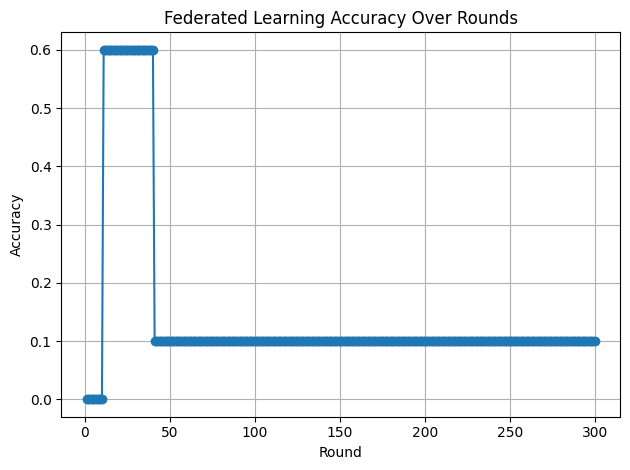

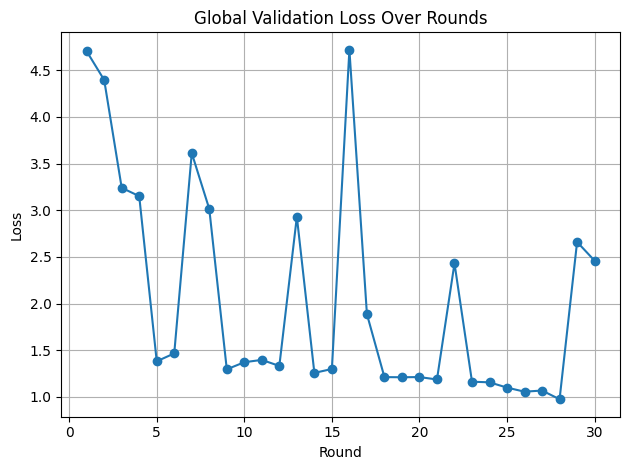

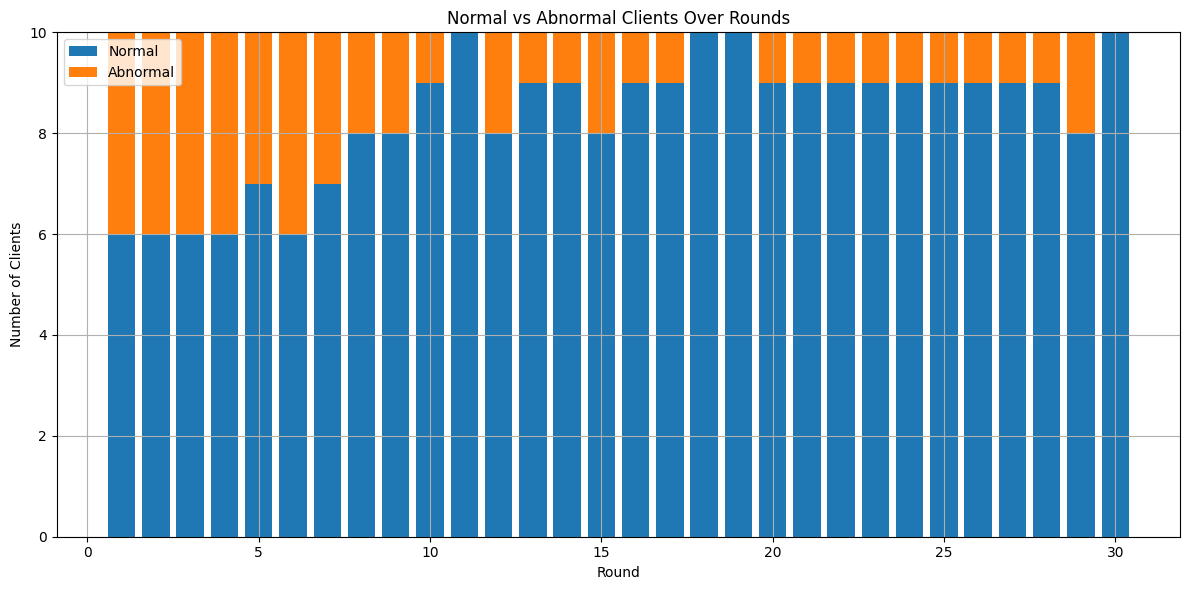

(ClientAppActor pid=15964) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=15964)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=15964)             entirely in future versions of Flower. [repeated 3x across cluster]


In [22]:
acc_tracker_3 = start_federated_learning(penalty_threshold=4, penalty_mode="accumulated")
ray.shutdown()

Files already downloaded and verified


C:\Users\USER\AppData\Local\Temp\ipykernel_16940\1159775073.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.dagmm_model.load_state_dict(torch.load(dagmm_model_path

(ClientAppActor pid=14116) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=47096) 
(ClientAppActor pid=47096)         
(ClientAppActor pid=30920) 
(ClientAppActor pid=30920)         
(ClientAppActor pid=7640) 
(ClientAppActor pid=7640)         
(ClientAppActor pid=7640) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=7640)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=7640)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=38504) 
(ClientAppActor pid=38504)         
(ClientAppActor pid=7492) 
(ClientAppActor pid=7492)         
(ClientAppActor pid=40620) 
(ClientAppActor pid=40620)         
(ClientAppActor pid=2204) 
(ClientAppActor pid=2204)         
(ClientAppActor pid=2204) WARNING :  

[INFO] Aggregating results for round 1...
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 7, True: echo, Pred: lazy
[DEBUG] CID: 6, True: random, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[ROUND 1] Accuracy: 0.1000 / F1: 0.0364


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=17660) 
(ClientAppActor pid=17660)         
(ClientAppActor pid=17660) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=17660)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=17660)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=40620) 
(ClientAppActor pid=40620)         
(ClientAppActor pid=7492) 
(ClientAppActor pid=7492)         
(ClientAppActor pid=38504) 
(ClientAppActor pid=38504)         
(ClientAppActor pid=30920) 
(ClientAppActor pid=30920)         
(ClientAppActor pid=40620) 
(ClientAppActor pid=40620)         
(ClientAppActor pid=17

(ClientAppActor pid=7640) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=47096) 
(ClientAppActor pid=47096)         
(ClientAppActor pid=17660) 
(ClientAppActor pid=17660)         
(ClientAppActor pid=40620) 
(ClientAppActor pid=40620)         
(ClientAppActor pid=30920) 
(ClientAppActor pid=30920)         
(ClientAppActor pid=38504) 
(ClientAppActor pid=38504)         
(ClientAppActor pid=38504) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=38504)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=38504)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=7492) 
(ClientAppActor pid=7492)         
(ClientAppActor pid=2204) 
(ClientAppActor pid=2204)         
(ClientAppActor pid=14116) 
(Cli

[INFO] Aggregating results for round 2...
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 6, True: random, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 7, True: echo, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[ROUND 2] Accuracy: 0.1000 / F1: 0.0364


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=14116) 
(ClientAppActor pid=14116)         
(ClientAppActor pid=14116) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=14116)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=14116)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=7492) 
(ClientAppActor pid=7492)         
(ClientAppActor pid=38504) 
(ClientAppActor pid=38504)         
(ClientAppActor pid=30920) 
(ClientAppActor pid=30920)         
(ClientAppActor pid=47096) 
(ClientAppActor pid=47096)         
(ClientAppActor pid=24000) 
(ClientAppActor pid=24000)         
(ClientAppActor pid=17

(ClientAppActor pid=17660) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=47096) 
(ClientAppActor pid=47096)         
(ClientAppActor pid=38504) 
(ClientAppActor pid=38504)         
(ClientAppActor pid=24000) 
(ClientAppActor pid=24000)         
(ClientAppActor pid=14116) 
(ClientAppActor pid=14116)         
(ClientAppActor pid=14116) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=14116)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=14116)             entirely in future versions of Flower. [repeated 4x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 3...
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 7, True: echo, Pred: lazy
[DEBUG] CID: 6, True: random, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[ROUND 3] Accuracy: 0.1000 / F1: 0.0364


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=14116) 
(ClientAppActor pid=14116)         
(ClientAppActor pid=14116) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=14116)             This is a deprecated feature. It will be removed
(ClientAppActor pid=14116)             entirely in future versions of Flower.
(ClientAppActor pid=38504) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=38504) 
(ClientAppActor pid=38504)             This is a deprecated feature. It will be removed
(ClientAppActor pid=38504)             e

(ClientAppActor pid=14116) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=17660) 
(ClientAppActor pid=17660)         
(ClientAppActor pid=7492) 
(ClientAppActor pid=7492)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 4...
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 6, True: random, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 7, True: echo, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[ROUND 4] Accuracy: 0.1000 / F1: 0.0364
[⚠️] Removing client 3 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 6 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 7 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 5 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Ori

INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=7492) 
(ClientAppActor pid=7492)         
(ClientAppActor pid=7492) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=7492)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=7492)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=7640) 
(ClientAppActor pid=7640)         
(ClientAppActor pid=40620) 
(ClientAppActor pid=40620)         
(ClientAppActor pid=38504) 
(ClientAppActor pid=38504)         
(ClientAppActor pid=30920) 
(ClientAppActor pid=30920)         
(ClientAppActor pid=7640) 
(ClientAppActor pid=7640)         
(ClientAppActor pid=40620) 
(

[INFO] Aggregating results for round 5...
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 6, True: lazy, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 5, True: small, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[ROUND 5] Accuracy: 0.1000 / F1: 0.0606
[⚠️] Removing client 3 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 6 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=24000) 
(ClientAppActor pid=24000)         
(ClientAppActor pid=24000) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=24000)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=24000)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=14116) 
(ClientAppActor pid=14116)         
(ClientAppActor pid=38504) 
(ClientAppActor pid=38504)         
(ClientAppActor pid=40620) 
(ClientAppActor pid=40620)         
(ClientAppActor pid=2204) 
(ClientAppActor pid=2204)         
(ClientAppActor pid=30920) 
(ClientAppActor pid=30920)         
(ClientAppActor pid=17

[INFO] Aggregating results for round 6...
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 5, True: small, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[ROUND 6] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 5 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 3 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=38504) 
(ClientAppActor pid=38504)         
(ClientAppActor pid=38504) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=38504)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=38504)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=24000) 
(ClientAppActor pid=24000)         
(ClientAppActor pid=40620) 
(ClientAppActor pid=40620)         
(ClientAppActor pid=14116) 
(ClientAppActor pid=14116)         
(ClientAppActor pid=30920) 
(ClientAppActor pid=30920)         
(ClientAppActor pid=47096) 
(ClientAppActor pid=47096)         
(ClientAppActor pid=

[INFO] Aggregating results for round 7...
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[ROUND 7] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 5 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 8 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=38504) 
(ClientAppActor pid=38504)         
(ClientAppActor pid=38504) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=38504)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=38504)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=40620) 
(ClientAppActor pid=40620)         
(ClientAppActor pid=14116) 
(ClientAppActor pid=14116)         
(ClientAppActor pid=24000) 
(ClientAppActor pid=24000)         
(ClientAppActor pid=30920) 
(ClientAppActor pid=30920)         
(ClientAppActor pid=14116) 
(ClientAppActor pid=14116)         
(ClientAppActor pid=

[INFO] Aggregating results for round 8...
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[ROUND 8] Accuracy: 0.1000 / F1: 0.0606
[⚠️] Removing client 5 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 6 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=17660) 
(ClientAppActor pid=17660)         
(ClientAppActor pid=17660) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=17660)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=17660)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=40620) 
(ClientAppActor pid=40620)         
(ClientAppActor pid=24000) 
(ClientAppActor pid=24000)         
(ClientAppActor pid=30920) 
(ClientAppActor pid=30920)         
(ClientAppActor pid=17660) 
(ClientAppActor pid=17660)         
(ClientAppActor pid=7640) 
(ClientAppActor pid=7640)         
(ClientAppActor pid=22

[INFO] Aggregating results for round 9...
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 5, True: random, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[ROUND 9] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 8 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 5 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=7492) 
(ClientAppActor pid=7492)         
(ClientAppActor pid=7492) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=7492)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=7492)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=24000) 
(ClientAppActor pid=24000)         
(ClientAppActor pid=30920) 
(ClientAppActor pid=30920)         
(ClientAppActor pid=7640) 
(ClientAppActor pid=7640)         
(ClientAppActor pid=17660) 
(ClientAppActor pid=17660)         
(ClientAppActor pid=2204) 
(ClientAppActor pid=2204)         
(ClientAppActor pid=38504) 
(

[INFO] Aggregating results for round 10...
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[ROUND 10] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 1 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 8 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=14116) 
(ClientAppActor pid=14116)         
(ClientAppActor pid=14116) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=14116)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=14116)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=30920) 
(ClientAppActor pid=30920)         
(ClientAppActor pid=2204) 
(ClientAppActor pid=2204)         
(ClientAppActor pid=17660) 
(ClientAppActor pid=17660)         
(ClientAppActor pid=38504) 
(ClientAppActor pid=38504)         
(ClientAppActor pid=47096) 
(ClientAppActor pid=47096)         
(ClientAppActor pid=76

[INFO] Aggregating results for round 11...
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 1, True: random, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[ROUND 11] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 1 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 8 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=7492) 
(ClientAppActor pid=7492)         
(ClientAppActor pid=7492) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=7492)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=7492)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=40620) 
(ClientAppActor pid=40620)         
(ClientAppActor pid=14116) 
(ClientAppActor pid=14116)         
(ClientAppActor pid=47096) 
(ClientAppActor pid=47096)         
(ClientAppActor pid=2204) 
(ClientAppActor pid=2204)         
(ClientAppActor pid=7640) 
(ClientAppActor pid=7640)         
(ClientAppActor pid=7640) WAR

[INFO] Aggregating results for round 12...
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[ROUND 12] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 2 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 8 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=7492) 
(ClientAppActor pid=7492)         
(ClientAppActor pid=7492) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=7492)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=7492)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=40620) 
(ClientAppActor pid=40620)         
(ClientAppActor pid=7640) 
(ClientAppActor pid=7640)         
(ClientAppActor pid=2204) 
(ClientAppActor pid=2204)         
(ClientAppActor pid=38504) 
(ClientAppActor pid=38504)         
(ClientAppActor pid=47096) 
(ClientAppActor pid=47096)         
(ClientAppActor pid=47096) WA

(ClientAppActor pid=17660) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=38504) 
(ClientAppActor pid=38504)         
(ClientAppActor pid=2204) 
(ClientAppActor pid=2204)         
(ClientAppActor pid=14116) 
(ClientAppActor pid=14116)         
(ClientAppActor pid=14116) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=14116)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=14116)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=7640) 
(ClientAppActor pid=7640)         
(ClientAppActor pid=7492) 
(ClientAppActor pid=7492)         
(ClientAppActor pid=47096) 
(ClientAppActor pid=47096)         
(ClientAppActor pid=24000) 
(ClientAppActor pid=24000)         
(ClientAppActor pid=24000) WARNING

[INFO] Aggregating results for round 13...
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 8, True: echo, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[ROUND 13] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 5 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 8 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=24000) 
(ClientAppActor pid=24000)         
(ClientAppActor pid=24000) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24000)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24000)             entirely in future versions of Flower.
(ClientAppActor pid=47096) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=47096) 
(ClientAppActor pid=47096)             This is a deprecated feature. It will be removed
(ClientAppActor pid=47096)             e

[INFO] Aggregating results for round 14...
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 8, True: lazy, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 5, True: random, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[ROUND 14] Accuracy: 0.1000 / F1: 0.0606
[⚠️] Removing client 8 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 5 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=17660) 
(ClientAppActor pid=17660)         
(ClientAppActor pid=17660) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=17660)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=17660)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=47096) 
(ClientAppActor pid=47096)         
(ClientAppActor pid=7492) 
(ClientAppActor pid=7492)         
(ClientAppActor pid=24000) 
(ClientAppActor pid=24000)         
(ClientAppActor pid=2204) 
(ClientAppActor pid=2204)         
(ClientAppActor pid=14116) 
(ClientAppActor pid=14116)         
(ClientAppActor pid=7640

[INFO] Aggregating results for round 15...
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[ROUND 15] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 8 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 0 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=30920) 
(ClientAppActor pid=30920)         
(ClientAppActor pid=30920) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=30920)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=30920)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=40620) 
(ClientAppActor pid=40620)         
(ClientAppActor pid=17660) 
(ClientAppActor pid=17660)         
(ClientAppActor pid=24000) 
(ClientAppActor pid=24000)         
(ClientAppActor pid=7640) 
(ClientAppActor pid=7640)         
(ClientAppActor pid=14116) 
(ClientAppActor pid=14116)         
(ClientAppActor pid=38

[INFO] Aggregating results for round 16...
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[ROUND 16] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 8 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 5 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=30920) 
(ClientAppActor pid=30920)         
(ClientAppActor pid=30920) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=30920)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=30920)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=40620) 
(ClientAppActor pid=40620)         
(ClientAppActor pid=7640) 
(ClientAppActor pid=7640)         
(ClientAppActor pid=24000) 
(ClientAppActor pid=24000)         
(ClientAppActor pid=47096) 
(ClientAppActor pid=47096)         
(ClientAppActor pid=38504) 
(ClientAppActor pid=38504)         
(ClientAppActor pid=14

(ClientAppActor pid=14116) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=47096) 
(ClientAppActor pid=47096)         
(ClientAppActor pid=47096) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=47096)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=47096)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=7640) 
(ClientAppActor pid=7640)         
(ClientAppActor pid=30920) 
(ClientAppActor pid=30920)         
(ClientAppActor pid=17660) 
(ClientAppActor pid=17660)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 17...
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 5, True: echo, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[ROUND 17] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 5 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 8 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=17660) 
(ClientAppActor pid=17660)         
(ClientAppActor pid=17660) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=17660)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=17660)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=30920) 
(ClientAppActor pid=30920)         
(ClientAppActor pid=7640) 
(ClientAppActor pid=7640)         
(ClientAppActor pid=17660) 
(ClientAppActor pid=17660)         
(ClientAppActor pid=47096) 
(ClientAppActor pid=47096)         
(ClientAppActor pid=24000) 
(ClientAppActor pid=24000)         
(ClientAppActor pid=22

[INFO] Aggregating results for round 18...
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[ROUND 18] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 8 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 6 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=14116) 
(ClientAppActor pid=14116)         
(ClientAppActor pid=14116) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=14116)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=14116)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=30920) 
(ClientAppActor pid=30920)         
(ClientAppActor pid=17660) 
(ClientAppActor pid=17660)         
(ClientAppActor pid=47096) 
(ClientAppActor pid=47096)         
(ClientAppActor pid=2204) 
(ClientAppActor pid=2204)         
(ClientAppActor pid=38504) 
(ClientAppActor pid=38504)         
(ClientAppActor pid=76

[INFO] Aggregating results for round 19...
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 8, True: random, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[ROUND 19] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 2 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 8 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=14116) 
(ClientAppActor pid=14116)         
(ClientAppActor pid=14116) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=14116)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=14116)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=47096) 
(ClientAppActor pid=47096)         
(ClientAppActor pid=30920) 
(ClientAppActor pid=30920)         
(ClientAppActor pid=2204) 
(ClientAppActor pid=2204)         
(ClientAppActor pid=24000) 
(ClientAppActor pid=24000)         
(ClientAppActor pid=14116) 
(ClientAppActor pid=14116)         
(ClientAppActor pid=17

[INFO] Aggregating results for round 20...
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 8, True: random, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[ROUND 20] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 8 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 2 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=38504) 
(ClientAppActor pid=38504)         
(ClientAppActor pid=38504) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=38504)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=38504)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=30920) 
(ClientAppActor pid=30920)         
(ClientAppActor pid=2204) 
(ClientAppActor pid=2204)         
(ClientAppActor pid=24000) 
(ClientAppActor pid=24000)         
(ClientAppActor pid=38504) 
(ClientAppActor pid=38504)         
(ClientAppActor pid=47096) 
(ClientAppActor pid=47096)         
(ClientAppActor pid=14

[INFO] Aggregating results for round 21...
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[ROUND 21] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 5 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 8 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=7492) 
(ClientAppActor pid=7492)         
(ClientAppActor pid=7492) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=7492)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=7492)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=30920) 
(ClientAppActor pid=30920)         
(ClientAppActor pid=2204) 
(ClientAppActor pid=2204)         
(ClientAppActor pid=24000) 
(ClientAppActor pid=24000)         
(ClientAppActor pid=14116) 
(ClientAppActor pid=14116)         
(ClientAppActor pid=30920) 
(ClientAppActor pid=30920)         
(ClientAppActor pid=47096) 

[INFO] Aggregating results for round 22...
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 8, True: lazy, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[ROUND 22] Accuracy: 0.1000 / F1: 0.0909
[⚠️] Removing client 8 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 3 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=7640) 
(ClientAppActor pid=7640)         
(ClientAppActor pid=7640) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=7640)             This is a deprecated feature. It will be removed
(ClientAppActor pid=7640)             entirely in future versions of Flower.
(ClientAppActor pid=40620) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=40620) 
(ClientAppActor pid=40620)             This is a deprecated feature. It will be removed
(ClientAppActor pid=40620)             entire

[INFO] Aggregating results for round 23...
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[ROUND 23] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 9 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 8 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=2204) 
(ClientAppActor pid=2204)         
(ClientAppActor pid=2204) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=2204)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=2204)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=7492) 
(ClientAppActor pid=7492)         
(ClientAppActor pid=47096) 
(ClientAppActor pid=47096)         
(ClientAppActor pid=24000) 
(ClientAppActor pid=24000)         
(ClientAppActor pid=40620) 
(ClientAppActor pid=40620)         
(ClientAppActor pid=30920) 
(ClientAppActor pid=30920)         
(ClientAppActor pid=30920) 

[INFO] Aggregating results for round 24...
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[ROUND 24] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 8 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 2 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=7640) 
(ClientAppActor pid=7640)         
(ClientAppActor pid=7640) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=7640)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=7640)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=38504) 
(ClientAppActor pid=38504)         
(ClientAppActor pid=30920) 
(ClientAppActor pid=30920)         
(ClientAppActor pid=7640) 
(ClientAppActor pid=7640)         
(ClientAppActor pid=47096) 
(ClientAppActor pid=47096)         
(ClientAppActor pid=17660) 
(ClientAppActor pid=17660)         
(ClientAppActor pid=24000) 

[INFO] Aggregating results for round 25...
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[ROUND 25] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 8 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 2 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=2204) 
(ClientAppActor pid=2204)         
(ClientAppActor pid=2204) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=2204)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=2204)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=38504) 
(ClientAppActor pid=38504)         
(ClientAppActor pid=7640) 
(ClientAppActor pid=7640)         
(ClientAppActor pid=24000) 
(ClientAppActor pid=24000)         
(ClientAppActor pid=47096) 
(ClientAppActor pid=47096)         
(ClientAppActor pid=17660) 
(ClientAppActor pid=17660)         
(ClientAppActor pid=40620) 

[INFO] Aggregating results for round 26...
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[ROUND 26] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 2 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 8 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=2204) 
(ClientAppActor pid=2204)         
(ClientAppActor pid=2204) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=2204)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=2204)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=17660) 
(ClientAppActor pid=17660)         
(ClientAppActor pid=40620) 
(ClientAppActor pid=40620)         
(ClientAppActor pid=38504) 
(ClientAppActor pid=38504)         
(ClientAppActor pid=7640) 
(ClientAppActor pid=7640)         
(ClientAppActor pid=47096) 
(ClientAppActor pid=47096)         
(ClientAppActor pid=38504) 

[INFO] Aggregating results for round 27...
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[ROUND 27] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 8 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 1 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=14116) 
(ClientAppActor pid=14116)         
(ClientAppActor pid=14116) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=14116)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=14116)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=7492) 
(ClientAppActor pid=7492)         
(ClientAppActor pid=2204) 
(ClientAppActor pid=2204)         
(ClientAppActor pid=47096) 
(ClientAppActor pid=47096)         
(ClientAppActor pid=17660) 
(ClientAppActor pid=17660)         
(ClientAppActor pid=38504) 
(ClientAppActor pid=38504)         
(ClientAppActor pid=2400

[INFO] Aggregating results for round 28...
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[ROUND 28] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 8 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 5 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=40620) 
(ClientAppActor pid=40620)         
(ClientAppActor pid=40620) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=40620)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=40620)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=47096) 
(ClientAppActor pid=47096)         
(ClientAppActor pid=14116) 
(ClientAppActor pid=14116)         
(ClientAppActor pid=7492) 
(ClientAppActor pid=7492)         
(ClientAppActor pid=38504) 
(ClientAppActor pid=38504)         
(ClientAppActor pid=17660) 
(ClientAppActor pid=17660)         
(ClientAppActor pid=76

[INFO] Aggregating results for round 29...
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[ROUND 29] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 1 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 8 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=2204) 
(ClientAppActor pid=2204)         
(ClientAppActor pid=2204) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=2204)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=2204)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=7492) 
(ClientAppActor pid=7492)         
(ClientAppActor pid=40620) 
(ClientAppActor pid=40620)         
(ClientAppActor pid=2204) 
(ClientAppActor pid=2204)         
(ClientAppActor pid=47096) 
(ClientAppActor pid=47096)         
(ClientAppActor pid=38504) 
(ClientAppActor pid=38504)         
(ClientAppActor pid=17660) 
(

[INFO] Aggregating results for round 30...
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[ROUND 30] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 4 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 8 with mode 'hybrid' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=14116) 
(ClientAppActor pid=14116)         
(ClientAppActor pid=14116) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=14116)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=14116)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=7492) 
(ClientAppActor pid=7492)         
(ClientAppActor pid=2204) 
(ClientAppActor pid=2204)         
(ClientAppActor pid=40620) 
(ClientAppActor pid=40620)         
(ClientAppActor pid=38504) 
(ClientAppActor pid=38504)         
(ClientAppActor pid=17660) 
(ClientAppActor pid=17660)         
(ClientAppActor pid=4709

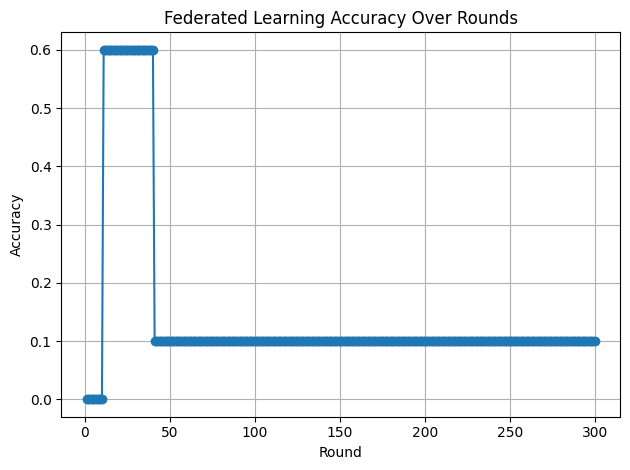

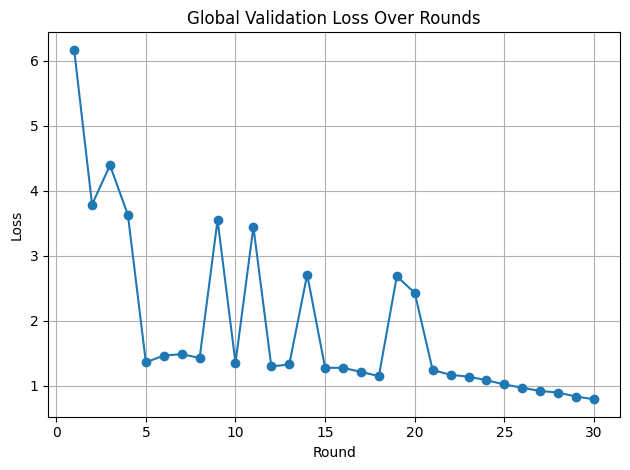

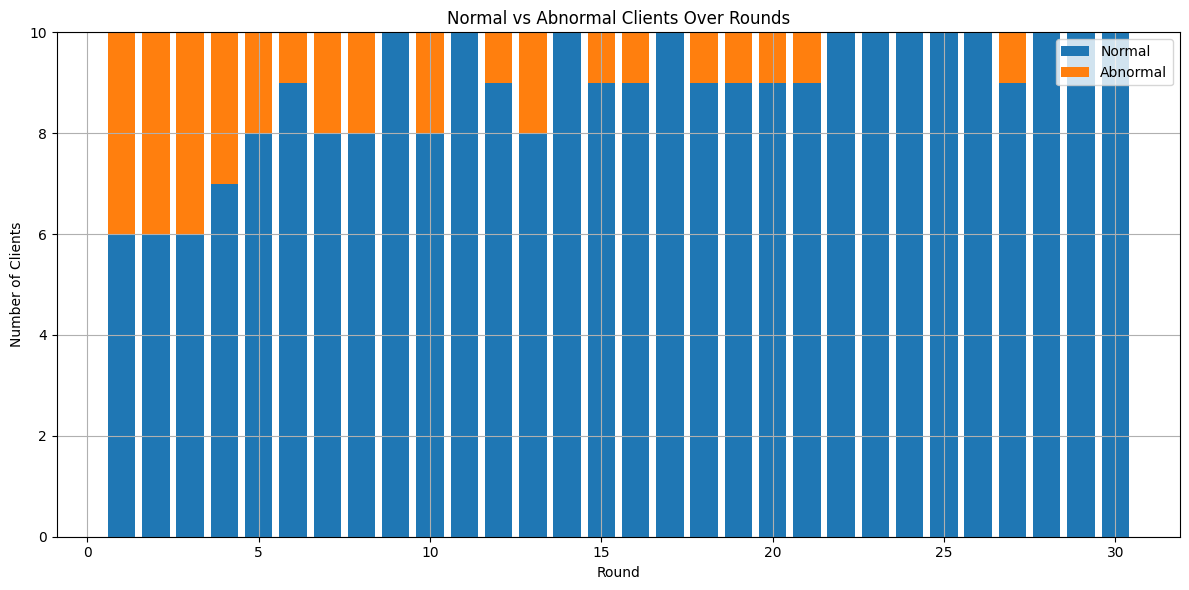

(ClientAppActor pid=30920) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=30920)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=30920)             entirely in future versions of Flower. [repeated 3x across cluster]


In [23]:
hyb_tracker_4_5 = start_federated_learning(penalty_threshold=4, penalty_mode="hybrid", switch_round=5)
ray.shutdown()

Files already downloaded and verified


C:\Users\USER\AppData\Local\Temp\ipykernel_16940\1159775073.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.dagmm_model.load_state_dict(torch.load(dagmm_model_path

(ClientAppActor pid=34360) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=32976) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=32976)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=32976)             entirely in future versions of Flower. [repeated 4x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 1...
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 6, True: random, Pred: lazy
[DEBUG] CID: 7, True: echo, Pred: lazy
[ROUND 1] Accuracy: 0.1000 / F1: 0.0364
[⚠️] Removing client 6 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 7 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=32976) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=32976)             This is a deprecated feature. It will be removed
(ClientAppActor pid=32976)             entirely in future versions of Flower.
(ClientAppActor pid=23576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)             This is a deprecated feature. It will be removed
(ClientAppActor pid=23576)             e

(ClientAppActor pid=43612) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 2...
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[ROUND 2] Accuracy: 0.2000 / F1: 0.0833
[⚠️] Removing client 1 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 5 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=38624) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=38624)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=38624)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=

(ClientAppActor pid=34360) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=32976) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=32976)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=32976)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 3...
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[ROUND 3] Accuracy: 0.2000 / F1: 0.0833
[⚠️] Removing client 2 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=38624) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=38624)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=38624)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=

(ClientAppActor pid=24388) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 2x across cluster]


(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=38624) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=38624)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=38624)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 4...
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 2, True: small, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[ROUND 4] Accuracy: 0.2000 / F1: 0.0833
[⚠️] Removing client 3 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=34360) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=34360)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=34360)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=

(ClientAppActor pid=12344) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 2x across cluster]


(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 5...
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 2, True: small, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[ROUND 5] Accuracy: 0.2000 / F1: 0.0833
[⚠️] Removing client 9 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=24888) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=24888)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=24888)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=

(ClientAppActor pid=34360) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 2x across cluster]


(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=38624) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=38624)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=38624)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         


(ClientAppActor pid=24320) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 6...
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 2, True: small, Pred: lazy
[ROUND 6] Accuracy: 0.2000 / F1: 0.0833
[⚠️] Removing client 3 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=38624) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=38624)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=38624)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=

(ClientAppActor pid=24320) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=24388) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=24388)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=24388)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         


(ClientAppActor pid=24888) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 7...
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 2, True: small, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[ROUND 7] Accuracy: 0.2000 / F1: 0.0833
[⚠️] Removing client 9 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=34360) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=34360)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=34360)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=

(ClientAppActor pid=43612) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=38624) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=38624)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=38624)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 8...
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 2, True: small, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[ROUND 8] Accuracy: 0.2000 / F1: 0.0833
[⚠️] Removing client 9 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=12344) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=12344)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=12344)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=

(ClientAppActor pid=32976) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 2x across cluster]


(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=24320) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=24320)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=24320)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 9...
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 2, True: small, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[ROUND 9] Accuracy: 0.2000 / F1: 0.0833
[⚠️] Removing client 4 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=24320) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=24320)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=24320)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=

(ClientAppActor pid=24888) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 3x across cluster]


(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=24388) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=24388)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=24388)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 10...
[DEBUG] CID: 7, True: lazy, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 2, True: small, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[ROUND 10] Accuracy: 0.2000 / F1: 0.0833
[⚠️] Removing client 3 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=24388) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=24388)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=24388)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=

(ClientAppActor pid=38624) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 3x across cluster]


(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=24888) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=24888)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=24888)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
INFO :      aggregate_fit: r

[INFO] Aggregating results for round 11...
[DEBUG] CID: 2, True: small, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 3, True: small, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[ROUND 11] Accuracy: 0.2000 / F1: 0.0833
[⚠️] Removing client 4 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=12344) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=12344)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=12344)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=

(ClientAppActor pid=20404) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 3x across cluster]


(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=38624) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=38624)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=38624)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=12344) 


(ClientAppActor pid=12344) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 3x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 12...
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 2, True: small, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 3, True: small, Pred: lazy
[DEBUG] CID: 4, True: echo, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[ROUND 12] Accuracy: 0.2000 / F1: 0.0833
[⚠️] Removing client 0 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=24320) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=24320)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=24320)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=

(ClientAppActor pid=12344) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         


(ClientAppActor pid=23576) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=24388) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=24388)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=24388)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 13...
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 3, True: small, Pred: lazy
[DEBUG] CID: 4, True: echo, Pred: lazy
[DEBUG] CID: 2, True: small, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 0, True: lazy, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[ROUND 13] Accuracy: 0.3000 / F1: 0.1538
[⚠️] Removing client 8 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=24320) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=24320)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=24320)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=

(ClientAppActor pid=24320) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 3x across cluster]


(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=24888) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=24888)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=24888)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 14...
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 2, True: small, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 0, True: lazy, Pred: lazy
[DEBUG] CID: 4, True: echo, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 3, True: small, Pred: lazy
[ROUND 14] Accuracy: 0.3000 / F1: 0.1538
[⚠️] Removing client 3 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=38624) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=38624)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=38624)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=

(ClientAppActor pid=12344) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 4x across cluster]


(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=38624) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=38624)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=38624)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         


(ClientAppActor pid=43612) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 3x across cluster]


(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 15...
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 2, True: small, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 4, True: echo, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 0, True: lazy, Pred: lazy
[ROUND 15] Accuracy: 0.3000 / F1: 0.1154
[⚠️] Removing client 3 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=24388) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=24388)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=24388)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=

(ClientAppActor pid=24388) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         


(ClientAppActor pid=23576) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=24320) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=24320)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=24320)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 16...
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 0, True: lazy, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[DEBUG] CID: 3, True: echo, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 4, True: echo, Pred: lazy
[DEBUG] CID: 2, True: small, Pred: lazy
[ROUND 16] Accuracy: 0.3000 / F1: 0.1538
[⚠️] Removing client 8 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=43612) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=43612)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=43612)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=

(ClientAppActor pid=32976) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 4x across cluster]


(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=20404) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=20404)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=20404)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         


(ClientAppActor pid=23576) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 4x across cluster]


(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=24888) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=24888)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=24888)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 17...
[DEBUG] CID: 4, True: echo, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 0, True: lazy, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 3, True: echo, Pred: lazy
[DEBUG] CID: 2, True: small, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[ROUND 17] Accuracy: 0.3000 / F1: 0.1154
[⚠️] Removing client 8 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=12344) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=12344)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=12344)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=

(ClientAppActor pid=24388) [EchoClient] Round 1: returning current parameters (initial phase)
(ClientAppActor pid=20404) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=24320) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=24320)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=24320)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=12344) 


(ClientAppActor pid=38624) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 3x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 18...
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 4, True: echo, Pred: lazy
[DEBUG] CID: 0, True: lazy, Pred: lazy
[DEBUG] CID: 3, True: echo, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 2, True: small, Pred: lazy
[ROUND 18] Accuracy: 0.3000 / F1: 0.1538
[⚠️] Removing client 8 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=12344) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=12344)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=12344)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=

(ClientAppActor pid=24320) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=20404) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=20404)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=20404)             entirely in future versions of Flower. [repeated 5x across cluster]


(ClientAppActor pid=20404) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 19...
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 2, True: small, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 4, True: echo, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 3, True: echo, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[DEBUG] CID: 0, True: lazy, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[ROUND 19] Accuracy: 0.3000 / F1: 0.1154
[⚠️] Removing client 8 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=24888) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=24888)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=24888)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=

(ClientAppActor pid=34360) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 4x across cluster]


(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=20404) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=20404)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=20404)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=23576) 


[INFO] Aggregating results for round 20...
[DEBUG] CID: 4, True: echo, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 3, True: echo, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 2, True: small, Pred: lazy
[DEBUG] CID: 0, True: lazy, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[ROUND 20] Accuracy: 0.3000 / F1: 0.1154
[⚠️] Removing client 8 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=24888) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=24888)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=24888)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=

(ClientAppActor pid=20404) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 5x across cluster]


(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=23576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=23576)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=23576)             entirely in future versions of Flower. [repeated 6x across cluster]


(ClientAppActor pid=23576) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 4x across cluster]


(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 21...
[DEBUG] CID: 3, True: echo, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 0, True: lazy, Pred: lazy
[DEBUG] CID: 8, True: echo, Pred: lazy
[DEBUG] CID: 2, True: small, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 4, True: echo, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[ROUND 21] Accuracy: 0.3000 / F1: 0.1538
[⚠️] Removing client 2 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=12344) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=12344)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=12344)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=

(ClientAppActor pid=34360) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 2x across cluster]


(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=24388) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 7x across cluster]
(ClientAppActor pid=24388)             This is a deprecated feature. It will be removed [repeated 7x across cluster]
(ClientAppActor pid=24388)             entirely in future versions of Flower. [repeated 7x across cluster]


(ClientAppActor pid=24388) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 4x across cluster]


(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 22...
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 0, True: lazy, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 8, True: echo, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 3, True: echo, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 4, True: echo, Pred: lazy
[ROUND 22] Accuracy: 0.3000 / F1: 0.1538
[⚠️] Removing client 2 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=24888) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=24888)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=24888)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=

(ClientAppActor pid=20404) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 2x across cluster]


(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=32976) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=32976)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=32976)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=24888) W

(ClientAppActor pid=24888) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 4x across cluster]


(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 23...
[DEBUG] CID: 8, True: echo, Pred: lazy
[DEBUG] CID: 3, True: echo, Pred: lazy
[DEBUG] CID: 0, True: lazy, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 4, True: echo, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[ROUND 23] Accuracy: 0.3000 / F1: 0.1538
[⚠️] Removing client 2 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=23576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=23576)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=23576)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=

(ClientAppActor pid=34360) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 2x across cluster]


(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=32976) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=32976)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=32976)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         


(ClientAppActor pid=38624) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 4x across cluster]


(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=12344) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12344)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12344)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 24...
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 3, True: echo, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[DEBUG] CID: 0, True: lazy, Pred: lazy
[DEBUG] CID: 4, True: echo, Pred: lazy
[DEBUG] CID: 2, True: echo, Pred: lazy
[DEBUG] CID: 8, True: echo, Pred: lazy
[ROUND 24] Accuracy: 0.3000 / F1: 0.2308
[⚠️] Removing client 7 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=23576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=23576)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=23576)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=

(ClientAppActor pid=20404) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 3x across cluster]


(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=38624) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=38624)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=38624)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         


(ClientAppActor pid=32976) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 4x across cluster]


(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=24320) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=24320)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=24320)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 25...
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 4, True: echo, Pred: lazy
[DEBUG] CID: 2, True: echo, Pred: lazy
[DEBUG] CID: 8, True: echo, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 0, True: lazy, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[DEBUG] CID: 3, True: echo, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[ROUND 25] Accuracy: 0.3000 / F1: 0.2308
[⚠️] Removing client 7 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=24320) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=24320)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=24320)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=

(ClientAppActor pid=20404) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 3x across cluster]


(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=43612) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=43612)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=43612)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=38624) 


(ClientAppActor pid=38624) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 5x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 26...
[DEBUG] CID: 3, True: echo, Pred: lazy
[DEBUG] CID: 2, True: echo, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 0, True: lazy, Pred: lazy
[DEBUG] CID: 8, True: echo, Pred: lazy
[DEBUG] CID: 4, True: echo, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 7, True: random, Pred: lazy
[ROUND 26] Accuracy: 0.2000 / F1: 0.1111
[⚠️] Removing client 7 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=43612) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=43612)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=43612)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=

(ClientAppActor pid=23576) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 2x across cluster]


(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=24388) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 7x across cluster]
(ClientAppActor pid=24388)             This is a deprecated feature. It will be removed [repeated 7x across cluster]
(ClientAppActor pid=24388)             entirely in future versions of Flower. [repeated 7x across cluster]
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=23576) 


(ClientAppActor pid=24888) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 6x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 27...
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 8, True: echo, Pred: lazy
[DEBUG] CID: 2, True: echo, Pred: lazy
[DEBUG] CID: 0, True: lazy, Pred: lazy
[DEBUG] CID: 3, True: echo, Pred: lazy
[DEBUG] CID: 4, True: echo, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[ROUND 27] Accuracy: 0.2000 / F1: 0.1111
[⚠️] Removing client 7 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=24320) 
(ClientAppActor pid=24320)         
(ClientAppActor pid=24320) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=24320)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=24320)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=

(ClientAppActor pid=24320) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=23576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=23576)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=23576)             entirely in future versions of Flower. [repeated 5x across cluster]


(ClientAppActor pid=23576) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=38624) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=38624)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=38624)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=43612) 


(ClientAppActor pid=32976) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 4x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 28...
[DEBUG] CID: 3, True: echo, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 2, True: echo, Pred: lazy
[DEBUG] CID: 8, True: echo, Pred: lazy
[DEBUG] CID: 4, True: echo, Pred: lazy
[DEBUG] CID: 0, True: lazy, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[ROUND 28] Accuracy: 0.2000 / F1: 0.1111
[⚠️] Removing client 7 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=38624) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=38624)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=38624)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=

(ClientAppActor pid=24888) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 2x across cluster]


(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=34360) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=34360)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=34360)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=24388) 


(ClientAppActor pid=43612) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 6x across cluster]


(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 29...
[DEBUG] CID: 0, True: lazy, Pred: lazy
[DEBUG] CID: 4, True: echo, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[DEBUG] CID: 3, True: echo, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 8, True: echo, Pred: lazy
[DEBUG] CID: 2, True: echo, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[ROUND 29] Accuracy: 0.3000 / F1: 0.2308
[⚠️] Removing client 5 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=23576) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=23576)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=23576)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=

(ClientAppActor pid=24320) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=34360) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=34360)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=34360)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=43612) 
(ClientAppActor pid=43612)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         


(ClientAppActor pid=43612) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=12344) 
(ClientAppActor pid=12344)         
(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=24888) 
(ClientAppActor pid=24888)         
(ClientAppActor pid=24888) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=24888)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=24888)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         


(ClientAppActor pid=24388) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 4x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 30...
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 4, True: echo, Pred: lazy
[DEBUG] CID: 7, True: lazy, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 3, True: echo, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 0, True: lazy, Pred: lazy
[DEBUG] CID: 2, True: echo, Pred: lazy
[DEBUG] CID: 5, True: random, Pred: lazy
[DEBUG] CID: 8, True: echo, Pred: lazy
[ROUND 30] Accuracy: 0.2000 / F1: 0.1111
[⚠️] Removing client 5 with mode 'f1_hybrid' and threshold 3
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=20404) 
(ClientAppActor pid=20404)         
(ClientAppActor pid=20404) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=20404)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=20404)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=34360) 
(ClientAppActor pid=34360)         
(ClientAppActor pid=23576) 
(ClientAppActor pid=23576)         
(ClientAppActor pid=24388) 
(ClientAppActor pid=24388)         
(ClientAppActor pid=38624) 
(ClientAppActor pid=38624)         
(ClientAppActor pid=32976) 
(ClientAppActor pid=32976)         
(ClientAppActor pid=

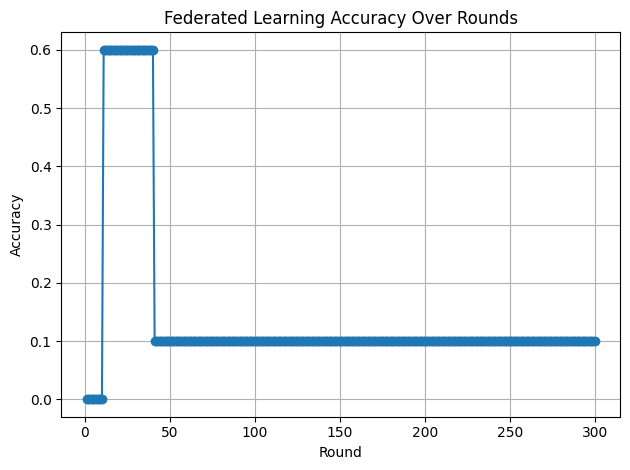

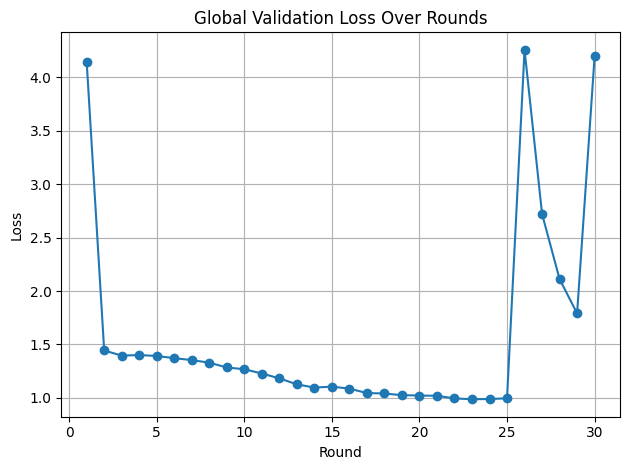

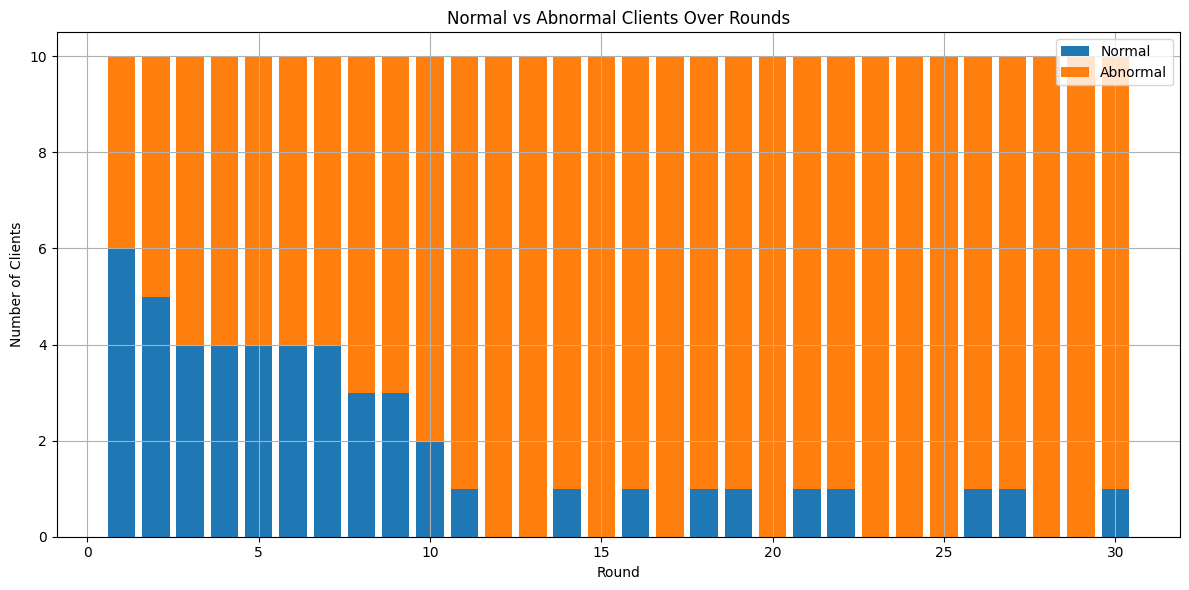

(ClientAppActor pid=23576) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=43612) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=43612)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=43612)             entirely in future versions of Flower. [repeated 3x across cluster]


In [25]:
hybf1_tracker_3_25 = start_federated_learning(penalty_threshold=3, penalty_mode="f1_hybrid", switch_round=25)
ray.shutdown()

Files already downloaded and verified


C:\Users\USER\AppData\Local\Temp\ipykernel_16940\1159775073.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.dagmm_model.load_state_dict(torch.load(dagmm_model_path

(ClientAppActor pid=24572) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=42420) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=42420)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=42420)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=26740) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature

[INFO] Aggregating results for round 1...
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 7, True: echo, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 6, True: random, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[ROUND 1] Accuracy: 0.1000 / F1: 0.0364


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=26740) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=26740)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=26740)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=32

(ClientAppActor pid=26740) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 2...
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 6, True: random, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 7, True: echo, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[ROUND 2] Accuracy: 0.1000 / F1: 0.0364


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=24572) 
(ClientAppActor pid=24572)         
(ClientAppActor pid=24572) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=24572)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=24572)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=23

(ClientAppActor pid=8012) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=42420) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=42420)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=42420)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=24572) 
(ClientAppActor pid=24572)         
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=32368) 


[INFO] Aggregating results for round 3...
[DEBUG] CID: 7, True: echo, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 6, True: random, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[ROUND 3] Accuracy: 0.1000 / F1: 0.0364


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=39696) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=39696)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=39696)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=

(ClientAppActor pid=26740) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 4...
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 5, True: lazy, Pred: lazy
[DEBUG] CID: 6, True: random, Pred: lazy
[DEBUG] CID: 7, True: echo, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[ROUND 4] Accuracy: 0.1000 / F1: 0.0364
[⚠️] Removing client 5 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 6 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 7 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 4 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total 

INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=22004) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=22004)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=22004)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=24572) 
(ClientAppActor pid=24572)         
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=

[INFO] Aggregating results for round 5...
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 6, True: small, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[ROUND 5] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 4 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 8 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=22004) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=22004)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=22004)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=24572) 
(ClientAppActor pid=24572)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=

[INFO] Aggregating results for round 6...
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 8, True: random, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 6, True: small, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[ROUND 6] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 8 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 6 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=37256) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=37256)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=37256)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=24572) 
(ClientAppActor pid=24572)         
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=

[INFO] Aggregating results for round 7...
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[ROUND 7] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 2 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 1 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=37256) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=37256)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=37256)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=

[INFO] Aggregating results for round 8...
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[ROUND 8] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 2 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 6 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=37256) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=37256)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=37256)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=

[INFO] Aggregating results for round 9...
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[ROUND 9] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 6 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 2 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=26740) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=26740)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=26740)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=4242

[INFO] Aggregating results for round 10...
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[ROUND 10] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 6 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 0 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=46580) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=46580)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=46580)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=24572) 
(ClientAppActor pid=24572)         
(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=

[INFO] Aggregating results for round 11...
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 6, True: random, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[ROUND 11] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 6 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 2 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=26740) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=26740)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=26740)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=24572) 
(ClientAppActor pid=24572)         
(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=

[INFO] Aggregating results for round 12...
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 2, True: small, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[ROUND 12] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 6 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 2 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=42420) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=42420)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=42420)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=

[INFO] Aggregating results for round 13...
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 9, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 6, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[ROUND 13] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 9 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)
[⚠️] Removing client 6 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=42420) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=42420)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=42420)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=37

(ClientAppActor pid=24572) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=37256) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=37256)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=37256)             entirely in future versions of Flower. [repeated 5x across cluster]


(ClientAppActor pid=37256) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 14...
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[ROUND 14] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 2 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=42420) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=42420)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=42420)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=23

(ClientAppActor pid=46580) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=32368) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=32368)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=32368)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         


(ClientAppActor pid=42420) [EchoClient] Round 1: returning current parameters (initial phase)


INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 15...
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[ROUND 15] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 2 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=8012) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=8012)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=8012)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=32368

(ClientAppActor pid=32368) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=39696) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=39696)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=39696)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         


(ClientAppActor pid=46580) [EchoClient] Round 1: returning current parameters (initial phase)


INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 16...
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[ROUND 16] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 2 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=42420) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=42420)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=42420)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=

(ClientAppActor pid=23612) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=24572) 
(ClientAppActor pid=24572)         
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=26740) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=26740)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=26740)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=46580) 
(C

[INFO] Aggregating results for round 17...
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 2, True: random, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[ROUND 17] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 2 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=46580) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=46580)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=46580)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=24572) 
(ClientAppActor pid=24572)         
(ClientAppActor pid=

(ClientAppActor pid=8012) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 2x across cluster]


(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=24572) 
(ClientAppActor pid=24572)         
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=23612) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=23612)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=23612)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
INFO :      aggregate_fit: r

[INFO] Aggregating results for round 18...
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 2, True: normal, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[ROUND 18] Accuracy: 0.0000 / F1: 0.0000
[⚠️] Removing client 2 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=32368) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=32368)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=32368)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=

(ClientAppActor pid=42420) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 2x across cluster]


(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 19...
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 2, True: lazy, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 1, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[ROUND 19] Accuracy: 0.1000 / F1: 0.0606
[⚠️] Removing client 1 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=32368) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=32368)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=32368)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=

(ClientAppActor pid=24572) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 2x across cluster]


(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=32368) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=32368)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=32368)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         


(ClientAppActor pid=42420) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 20...
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 2, True: lazy, Pred: lazy
[ROUND 20] Accuracy: 0.1000 / F1: 0.0606
[⚠️] Removing client 5 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=22004) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=22004)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=22004)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=23

(ClientAppActor pid=32368) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         


(ClientAppActor pid=22004) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=42420) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=42420)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=42420)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=24572) 
(ClientAppActor pid=24572)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 21...
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 2, True: lazy, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[ROUND 21] Accuracy: 0.1000 / F1: 0.0606
[⚠️] Removing client 4 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=24572) 
(ClientAppActor pid=24572)         
(ClientAppActor pid=24572) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=24572)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=24572)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=39

(ClientAppActor pid=32368) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 2x across cluster]


(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=22004) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=22004)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=22004)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=26740) WAR

(ClientAppActor pid=26740) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 2x across cluster]


(ClientAppActor pid=24572) 
(ClientAppActor pid=24572)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 22...
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 2, True: lazy, Pred: lazy
[ROUND 22] Accuracy: 0.1000 / F1: 0.0606
[⚠️] Removing client 8 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=24572) 
(ClientAppActor pid=24572)         
(ClientAppActor pid=24572) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=24572)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=24572)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=37

(ClientAppActor pid=22004) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=46580) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=46580)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=46580)             entirely in future versions of Flower. [repeated 5x across cluster]


(ClientAppActor pid=46580) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=24572) 
(ClientAppActor pid=24572)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 23...
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 8, True: random, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 2, True: lazy, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[ROUND 23] Accuracy: 0.1000 / F1: 0.0455
[⚠️] Removing client 8 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=39696) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=39696)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=39696)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=26

(ClientAppActor pid=46580) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 2x across cluster]


(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=8012) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=8012)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=8012)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=22004) 
(Clie

(ClientAppActor pid=22004) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 24...
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 2, True: lazy, Pred: lazy
[DEBUG] CID: 8, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[ROUND 24] Accuracy: 0.1000 / F1: 0.0606
[⚠️] Removing client 8 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=42420) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=42420)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=42420)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=24

(ClientAppActor pid=24572) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=8012) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=8012)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=8012)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         


(ClientAppActor pid=8012) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 25...
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 2, True: lazy, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 5, True: normal, Pred: lazy
[ROUND 25] Accuracy: 0.1000 / F1: 0.0455
[⚠️] Removing client 5 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=46580) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=46580)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=46580)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=

(ClientAppActor pid=26740) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 2x across cluster]


(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=8012) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=8012)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=8012)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=24572) 
(ClientAppActor pid=24572)         
(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         


(ClientAppActor pid=24572) [EchoClient] Round 1: returning current parameters (initial phase)
(ClientAppActor pid=22004) [EchoClient] Round 1: returning current parameters (initial phase)


INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 26...
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 2, True: lazy, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 5, True: small, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 0, True: normal, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[ROUND 26] Accuracy: 0.1000 / F1: 0.0455
[⚠️] Removing client 0 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=8012) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=8012)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=8012)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=22004) 

(ClientAppActor pid=32368) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=46580) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=46580)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=46580)             entirely in future versions of Flower. [repeated 6x across cluster]


(ClientAppActor pid=46580) [EchoClient] Round 1: returning current parameters (initial phase)


(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 27...
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 5, True: small, Pred: lazy
[DEBUG] CID: 0, True: lazy, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 2, True: lazy, Pred: lazy
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[ROUND 27] Accuracy: 0.2000 / F1: 0.0833
[⚠️] Removing client 7 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=42420) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=42420)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=42420)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=

(ClientAppActor pid=8012) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 2x across cluster]


(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=23612) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=23612)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=23612)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=24572) 
(ClientAppActor pid=24572)         
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 28...
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 2, True: lazy, Pred: lazy
[DEBUG] CID: 0, True: lazy, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 5, True: small, Pred: lazy
[ROUND 28] Accuracy: 0.2000 / F1: 0.0833
[⚠️] Removing client 7 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=32368) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=32368)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=32368)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=

(ClientAppActor pid=26740) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 3x across cluster]


(ClientAppActor pid=8012) 
(ClientAppActor pid=8012)         
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=24572) 
(ClientAppActor pid=24572)         
(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=42420) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=42420)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=42420)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
INFO :      aggregate_fit: rec

[INFO] Aggregating results for round 29...
[DEBUG] CID: 3, True: normal, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 2, True: lazy, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 5, True: small, Pred: lazy
[DEBUG] CID: 0, True: lazy, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[ROUND 29] Accuracy: 0.2000 / F1: 0.0833
[⚠️] Removing client 3 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=23612) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=23612)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=23612)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=24572) 
(ClientAppActor pid=24572)         
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=

(ClientAppActor pid=24572) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 3x across cluster]


(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=46580) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=46580)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=46580)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=23612) 
(ClientAppActor pid=23612)         
(ClientAppActor pid=26740) 
(ClientAppActor pid=26740)         
(ClientAppActor pid=39696) 


(ClientAppActor pid=39696) [EchoClient] Round 1: returning current parameters (initial phase) [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] Aggregating results for round 30...
[DEBUG] CID: 1, True: echo, Pred: lazy
[DEBUG] CID: 8, True: small, Pred: lazy
[DEBUG] CID: 9, True: echo, Pred: lazy
[DEBUG] CID: 4, True: normal, Pred: lazy
[DEBUG] CID: 5, True: small, Pred: lazy
[DEBUG] CID: 0, True: lazy, Pred: lazy
[DEBUG] CID: 7, True: normal, Pred: lazy
[DEBUG] CID: 6, True: echo, Pred: lazy
[DEBUG] CID: 2, True: lazy, Pred: lazy
[DEBUG] CID: 3, True: random, Pred: lazy
[ROUND 30] Accuracy: 0.2000 / F1: 0.0667
[⚠️] Removing client 3 with mode 'f1_consecutive' and threshold 4
[DEBUG] After replacement, total clients: 10 (Simulated), 10 (Original)


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=46580) 
(ClientAppActor pid=46580)         
(ClientAppActor pid=46580) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=46580)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=46580)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=42420) 
(ClientAppActor pid=42420)         
(ClientAppActor pid=37256) 
(ClientAppActor pid=37256)         
(ClientAppActor pid=32368) 
(ClientAppActor pid=32368)         
(ClientAppActor pid=39696) 
(ClientAppActor pid=39696)         
(ClientAppActor pid=22004) 
(ClientAppActor pid=22004)         
(ClientAppActor pid=

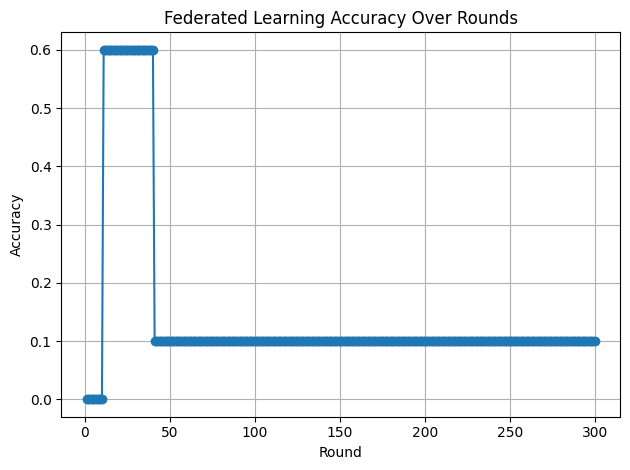

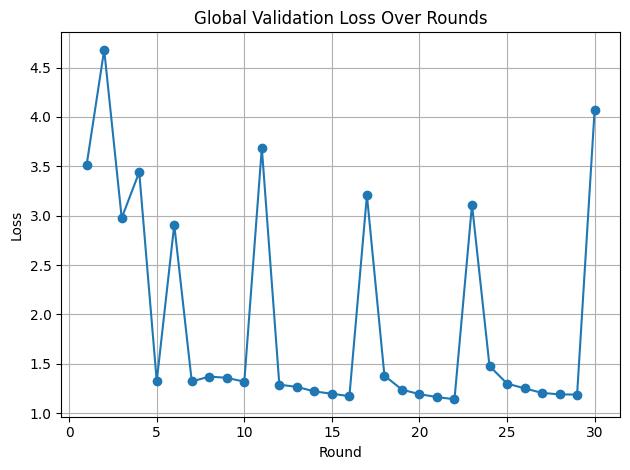

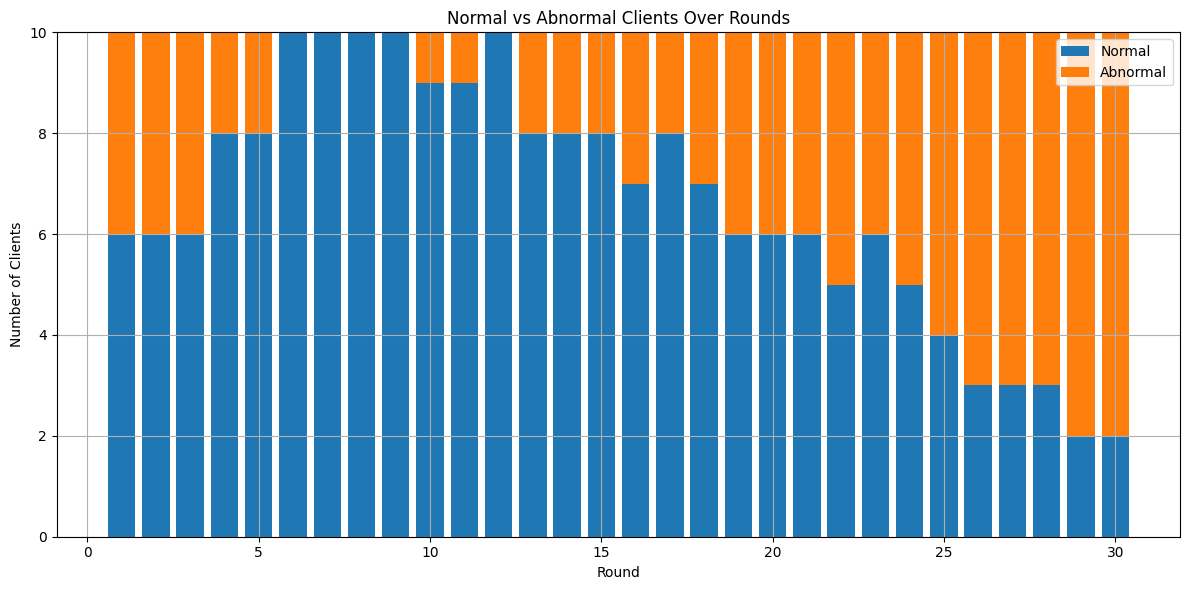

(ClientAppActor pid=23612) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=23612)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=23612)             entirely in future versions of Flower. [repeated 4x across cluster]


In [24]:
f1_con_tracker_4 = start_federated_learning(penalty_threshold=4, penalty_mode="f1_consecutive")
ray.shutdown()